# Setup

## Imports and Configuration

In [ ]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import os
import re
import json
from datetime import datetime
from anndata import AnnData
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import corescpy as cr

pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(20, 20))

palette = "tab20"

# Column Names (from Metadata & To Be Created)
col_sample_id_o, col_sample_id = "Sample ID", "Sample"  # in metadata, new
col_subject = "Patient"  # in metadata file
# col_batch = "Slide"  # in metadata file
col_batch = None  # in metadata file
col_inflamed, col_stricture = "Inflamed", "Stricture"  # in metadata file
col_condition = "Condition"  # constructed from col_inflamed & col_stricture
col_path = "file_path"  # column in metadata in which to store data file path
col_cell_type = "Annotation"  # for eventual cluster annotation column


def construct_file(sample=None, run="CHO-001", slide=None,
                   date=None, timestamp=None,
                   panel_id="TUQ97N", prefix="output-XETG00189",
                   project_owner="EA", directory=None):
    """Construct file path from information."""
    if "outputs" not in directory and os.path.exists(
            os.path.join(directory, "outputs")):
        directory = os.path.join(directory, "outputs")
    if sample is None:
        run = [run] if isinstance(run, str) else run
        panel_id = [panel_id] * len(run) if isinstance(
            panel_id, str) else panel_id
        fff = []
        for i, x in enumerate(run):
            d_x = os.path.join(directory, panel_id[i], x)
            fff += [os.path.join(d_x, y) for y in os.listdir(d_x)]
        return fff
    if isinstance(sample, str):
        sample = [sample]
    print(directory)
    panel_id, prefix, project_owner, slide, date, timestamp = [
        [x] * len(sample) if isinstance(x, str) else list(x) if x else x
        for x in [panel_id, prefix, project_owner, slide, date, timestamp]]
    run = [run] * len(sample) if isinstance(run, (str, int, float)) else run
    block = ["-".join(i) for i in zip(sample, panel_id, project_owner)]
    fff = [f"{prefix[i]}__{slide[i]}__{block[i]}" for i in range(len(sample))]
    if date is None or timestamp is None:
        for i, x in enumerate(fff):  # iterate current file stems
            ddd = os.path.join(directory, panel_id[i], run[i])
            print(ddd)
            matches = sum([x in d for d in os.listdir(ddd)])
            if  matches != 1:
                raise ValueError(f"{x} found in 0 or multiple file paths",
                                 f"\n\n{os.listdir(ddd)}")
            fff[i] = os.path.join(ddd, np.array(os.listdir(ddd))[np.where([
                x in d for d in os.listdir(ddd)])[0][0]])  # find match
    else:
        fff = [os.path.join(directory, panel_id[i], run[i],
                            f"{x}__{date[i]}__{timestamp[i]}")
               for i, x in enumerate(fff)]
    return fff


def perform_qc_concatenated(selves):
    hue = selves[0]._columns["col_sample_id"]
    ids = [str(s.rna.obs[hue].iloc[0]) for s in selves]
    patterns = [("MT-", "mt-"), ("RPS", "RPL", "rps", "rpl"), (
        "^HB[^(P)]", "^hb[^(p)]")]  # pattern matching for gene symbols
    patterns = dict(zip(["mt", "ribo", "hb"], patterns))  # dictionary
    names = dict(zip(["mt", "ribo", "hb"],
                        ["Mitochondrial", "Ribosomal", "Hemoglobin"]))
    p_names = [names[k] if k in names else k for k in patterns]  # "pretty"
    patterns_names = dict(zip(patterns, p_names))  # map abbreviated to pretty
    adata = AnnData.concatenate(
        *[x.rna for x in selves], join="outer", batch_key=hue,
        batch_categories=ids, index_unique=None, uns_merge="unique")
    qc_vars = []  # to hold mt, rb, hb, etc. if present in data
    for k in patterns:  # calculate MT, RB, HB counts
        gvars = adata.var_names.str.startswith(patterns[k])
        if any(gvars):
            qc_vars += [k]
        adata.var[k] = gvars
    pct_n = [f"pct_counts_{k}" for k in qc_vars]  # "% counts" variables
    cgs = selves[0]._columns["col_gene_symbols"] if selves[
        0].rna.var.index.values[0] not in selves[0].rna.var_names else None
    adata.obs = adata.obs.astype({col_condition: "category"})
    ggg = list(set(genes).intersection(adata.var_names))
    ctm = list(set(["n_genes_by_counts", "total_counts", "log1p_total_counts",
                    "cell_area", "nucleus_area"]
                ).intersection(adata.obs.columns))
    vam = pct_n + ctm + [hue]  # QC variable names
    mets_df = adata.obs[vam].rename_axis("Metric", axis=1).rename(
        {"total_counts": "Total Counts in Cell", "cell_area": "Cell Area",
        "nucleus_area": "Nucleus Area",
        "n_genes_by_counts": "Genes Detected in Cell",
        "log1p_total_counts": "Log-Normalized Total Counts",
        **patterns_names}, axis=1)  # rename
    fff = sb.pairplot(
        mets_df, hue=hue, height=3, diag_kind="hist",
        plot_kws=dict(marker=".", linewidth=0.05))  # pair
    return adata

## Options

In [ ]:
# Main Directories
# Replace manually or mirror my file/directory tree in your home (`ddu`)
ddu = os.path.expanduser("~")
ddm = "/mnt/cho_lab" if os.path.exists("/mnt/cho_lab") else "/mnt"  # Spark?
ddl = f"{ddm}/disk2/elizabeth/data/shared-xenium-library" if (
    "cho" in ddm) else os.path.join(ddu, shared-xenium-library)
ddx = f"{ddm}/bbdata0/xenium"  # mounted drive Xenium folder
out_dir = os.path.join(ddl, "outputs", "TUQ97N", "nebraska")  # None = no save
d_path = "/mnt/cho_lab/disk2/elizabeth/data"  # for other data
file_ann = os.path.join(ddu, "corescpy/examples/annotation_guide.xlsx")  # AG
col_assignment = "Bin"  # which column from annotation file to use
file_mdf = os.path.join(ddl, "Xenium_Samples_03152024.xlsx")  # metadata

# Tangram
col_tangram = "tangram_prediction"
# col_cell_type_sc, file_sc = "ClusterAnnotation", str(
#     f"{d_path}/2023-05-12_CombinedCD-v2_ileal_new.h5ad")
col_cell_type_sc, file_sc = "cell_type", f"{d_path}/elmentaite_ileal.h5ad"

# Directories & Metadata
run = "CHO-006"
samples = "all"
# samples = ["50452A", "50452B", "50452C"]
# samples = ["50564A4", "50618B5"]

# Input/Output Options
plot_all_qc = False
reload = False

# Computing Resources
gpu = False
sc.settings.n_jobs = 4
sc.settings.max_memory = 150

# Processing & Clustering Options
resolution = 0.5
min_dist = 0.3
n_comps = 50
# custom_thresholds = {col_qscore: [, None]}
genes_subset, use_highly_variable = True, False  # genes to use in clustering
kws_pp = dict(cell_filter_pmt=None, cell_filter_ncounts=[50, None],
              cell_filter_ngene=[30, None], gene_filter_ncell=[3, None],
              gene_filter_ncounts=[3, None], custom_thresholds=None,
              kws_scale=dict(max_value=10, zero_center=True))

# After this point, no more options to specify
# Just code to infer the data file path from your specifications
# and construct argument dictionaries and manipulate metadata and such.

# Read Metadata & Other Information
annot_df = pd.read_excel(file_ann)
metadata = pd.read_excel(file_mdf, dtype={"Slide ID": str}).rename(
    {"Name": col_subject, "Slide ID": col_batch,
     "Inflammation Status": col_inflamed}, axis=1)
if samples not in ["all", None]:  # subset by sample ID?
    metadata = metadata.set_index(col_sample_id_o).loc[samples].reset_index()

# Construct Clustering Argument Keyword Dictionaries
if genes_subset is True:
    genes_subset = list(annot_df.iloc[:, 0])
kws_umap = dict(min_dist=min_dist, method="rapids" if gpu else "umap")
kws_cluster = dict(use_gpu=gpu, kws_umap=kws_umap, kws_neighbors=None,
                   use_highly_variable=use_highly_variable, n_comps=n_comps,
                   genes_subset=genes_subset, resolution=resolution)

# Revise Metadata & Construct Variables from Options
metadata.loc[:, col_stricture] = metadata[col_stricture].replace(
    {"yes": "Stricture", "no": "None"})  # stricture column
metadata.loc[:, col_condition] = metadata.apply(lambda x: "Stricture" if x[
    col_stricture] == "Stricture" else x[col_inflamed].capitalize(), axis=1)
metadata.loc[:, col_sample_id] = metadata[[col_condition, col_sample_id_o]
                                          ].apply("-".join, axis=1)
metadata = metadata.set_index(col_sample_id)
fff = np.array(construct_file(run=run, directory=ddx))
samps = np.array([i.split("__")[2].split("-")[0] for i in fff])
for x in metadata[col_sample_id_o]:
    metadata.loc[metadata[col_sample_id_o] == x, col_path] = fff[np.where(
        samps == x)[0][0]] if len(np.where(samps == x)[0]) > 0 else np.nan
metadata = metadata.dropna(subset=[col_path])
file_path_dict = dict(zip(metadata.index.values, metadata["file_path"]))
kws_init = dict(col_batch=col_batch, col_subject=col_subject,
                col_sample_id=col_sample_id, col_cell_type=col_cell_type)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Annotation File
assign = pd.read_excel(file_ann, index_col=0).dropna(
    subset=col_assignment).rename_axis("Gene")
marker_genes_dict = dict(assign.reset_index().groupby(col_assignment).apply(
    lambda x: list(pd.unique(x.Gene))))  # to marker dictionary

# Print Metadata
metadata

# Genes
# genes = ["CDKN1A", "CDKN2A", "TP53", "PLAUR", "PTGER4", "FTL", "IL6ST"]
# cell_types = ["ILC3", "LTi-like NCR+ ILC3", "LTi-like NCR- ILC3",
#               "ILCP", "Macrophages", "Stem cells"]
# palette = ["r", "tab:pink", "m", "b", "tab:brown", "cyan"]
# High in inf. vs. un
# OSM
# IL13
# IL1B
# IL6
# TNF
# S100A8
# S100A9
# ------------------------------
# High in stricture vs inf/un
# PDGFRA
# IL6ST
# PTPN1
# IFNG

## Re-Name Files in Standard Form Using Object

In [ ]:
# fff = list(pd.Series([x if "h5ad" in x else np.nan for x in os.listdir(
#     out_dir)]).dropna())
# frn = []
# for x in fff:
#     ann = sc.read(os.path.join(out_dir, x))
#     kwu = re.sub("{", "", re.sub("}", "", str(ann.obs.iloc[0].kws_umap))
#                  ).split(", ")
#     kwu = np.array(kwu)[np.where(["min_dist" in x for x in kwu])[
#         0]][0].split(": ")[1]
#     frn += [str(f"{str(ann.obs.iloc[0][col_sample_id])}__"
#                 f"res{str(ann.obs.iloc[0].resolution)}"
#                 f"_dist{kwu}_npc{ann.varm['PCs'].shape[1]}")]
# frd = dict(zip([os.path.join(out_dir, i) for i in fff], [os.path.join(
#     out_dir, re.sub("[.]", "pt", re.sub("[.]h5ad", "", i)) + ".h5ad")
#                                                          for i in frn]))
# frd
# # for x in frd:
# #     os.system(f"mv {x} {frd[x]}")

# Data

## Loading

In [ ]:
%%time

# Load Spatial Data
suff = str(f"res{re.sub('[.]', 'pt', str(resolution))}_dist"
           f"{re.sub('[.]', 'pt', str(min_dist))}_npc{n_comps}")  # file end
selves, paths_he = [], []
file_mk, out_files = [[] if out_dir else None] * 2
for x in metadata.index.values:
    self = cr.Spatial(metadata.loc[x][col_path], library_id=x, **kws_init)
    for i in metadata:  # add metadata for subject
        self.rna.obs.loc[:, i] = str(metadata.loc[x][i])  # add metadata
    selves += [self]
    paths_he += [os.path.join(metadata.loc[x][
        col_path], "aux_outputs/image_he.tif")]  # H&E paths
    if out_dir is not None:
        out_files += [os.path.join(out_dir, f"{x}__{suff}")]
        file_mk += [os.path.join(out_dir, f"{x}__{suff}_markers.csv")]

# Concatenate AnnData Objects & Perform QC
if plot_all_qc is True:
    adata = perform_qc_concatenated(selves)

# Reload Processed & Clustered Data (Optionally)
if reload is True:
    for i, s in enumerate(selves):
        f_m = file_mk[i] if file_mk and os.path.exists(file_mk[i]) else None
        s.update_from_h5ad(file=out_files[i], file_path_markers=f_m)

In [ ]:
# threshold = 20
# self.adata.points["transcripts"][self.adata.points["transcripts"].qv >= threshold].compute().shape
print(dir(self.adata), "\n\n")
self.adata

In [ ]:
    import tifffile as tiff

    p = paths_he[i]

    img = tiff.imread(p)
    mg = PIL.moveaxis(img, -1, 1)[0]
    img = Image2DModel.parse(img, transformations={"global": Identity()},
                             dims=("c", "y", "x"))
    self.adata.add_image("morphology_he", img)

In [ ]:
from PIL import Image, ImageFile
import spatialdata

Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

img = Image.open(paths_he[i]).convert("RGB")
# img = np.asarray(Image.open(paths_he[i]).convert(
#     "RGB"), dtype=np.float32) / 255
self.adata.add_image("morphology_he",
                     spatialdata.models.Image2DModel.parse(img))

In [ ]:
self.adata.table.uns[self._spatial_key]["Stricture-50452C"]["images"]["Stricture-50452C___morphology_mip_scale3"].show()

In [ ]:
libs = [self._library_id] if isinstance(self._library_id, str) else self._library_id
for s in libs:
    self.adata.table.uns[self._spatial_key][s]["images"][key] = sq.im.ImageContainer(
                adata.images[x][i].image, library_id=library_id)

In [ ]:
self.adata.pl.render_shapes().pl.show()

In [ ]:
cr.pl.plot_tiff()

In [ ]:
self.adata.pl.render_shapes().pl.show()

In [ ]:
dir(plotter)

In [ ]:
dir(self.adata)

In [ ]:
self.adata.images

In [ ]:
self = selves[1]

sdata_im = self.adata.aggregate(values="transcripts", by="cell_boundaries", agg_func="count")
sdata_im

In [ ]:
self.adata.points["transcripts"].feature_name.compute()

In [ ]:
self.adata.points

In [ ]:
self.adata.shapes["cell_boundaries"]

In [ ]:
plotter = spatialdata_plot.pl.basic.PlotAccessor(self.adata)

In [ ]:
from spatialdata_io.readers.xenium import xenium_aligned_image

img = xenium_aligned_image("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/CHO-001/output-XETG00189__0010700__50452A-TUQ97N-EA__20240126__205019/aux_outputs/50452-A (FFPE) - 2024-01-16 11.36.14.tif", None)

In [ ]:
dir(img)

In [ ]:
import tiffile

dir(tiffile)

In [ ]:
plotter.render_shapes(elements="cell_boundaries").pl.show()

In [ ]:
plotter.render_points(elements="transcripts", color="feature_name", groups="CDKN1A").pl.show("global")

In [ ]:
self.show(kinds=["images", "shapes"], elements=["cell_boundaries", "morphology_mip"], color={"morphology_mip": "Annotation"})
# self.show(kinds="all", elements=["IL23", "cell_boundaries", "morphology_mip"])

In [ ]:
import spatialdata_plot

plotter = spatialdata_plot.pl.basic.PlotAccessor(self.adata)
# # plotter.render_images("morphology_focus").pl.show()
# # plotter.render_points(elements="transcripts", color="CDKN1A").pl.show()
# plotter.render_shapes(elements="cell_boundaries", color="green").pl.show()
plotter.render_shapes(elements="cell_boundaries", color="Annotation").pl.show("global")

In [ ]:
plotter.render_points(elements=None, color="green", groups=["STAT1"]).pl.show("global")

In [ ]:
self

In [ ]:
self.adata.pl.render_images().pl.render_shapes().pl.show()

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

sdata.render_images().pl.show(ax=axs[0])
sdata.pl.render_labels().pl.show(ax=axs[1])
sdata.pl.render_shapes().pl.show(ax=axs[2])
sdata.pl.render_images().pl.render_labels().pl.render_shapes().pl.show()

In [ ]:
transcripts = self.read_parquet()
transcripts

In [ ]:
dir(self.adata.images["morphology_mip"]["scale0"])

In [ ]:
self.adata.images["morphology_mip"]["scale0"]

In [ ]:

dir(self.rna.uns["spatial"][self._library_id]["images"]["Stricture-50452C___morphology_mip_scale0"])

## Check Genes

In [ ]:
for s in selves:
    _ = s.read_panel(directory=str(metadata.loc[s._library_id][col_path]))

## Explore

In [ ]:
[s.print() for s in selves]
# kim = f"{self._library_id}{cr.pp.SPATIAL_IMAGE_KEY_SEP}morphology_mip"
# s.adata.pl.render_images(kim)
# print(dir(s.adata.images[kim]))
# s.adata.shapes["nucleus_boundaries"]

# Whole Process Example

## Nebraska

In [ ]:
# self = selves[0]
# _ = self.preprocess(**kws_pp)
# _ = self.cluster(**kws_cluster)
# # self.adata.write(out_files[i], overwrite=True)  # optional, write object
# self.calculate_centrality(n_jobs=4)
# self.find_cooccurrence(figsize=(60, 20), kws_plot=dict(wspace=3))
# self.find_svgs(genes=genes, method="moran", n_perms=10, kws_plot=dict(
#     legend_fontsize="large"), figsize=(15, 15))
# self.calculate_receptor_ligand(col_condition=False, p_threshold=0.001,
#                                remove_ns=True, figsize=(20, 20))

## Bare Squidpy

In [ ]:
# import squidpy as sq
# import scanpy as sc
# import spatialdata_io as sdio

# col_cell_type = "leiden"
# n_jobs = 4
# file = file_path_dict[list(file_path_dict.keys())[0]]

# sdata = sdio.xenium(file, n_jobs=n_jobs)

# sq.gr.spatial_neighbors(sdata.table)
# sc.pp.pca(sdata.table)
# sc.pp.neighbors(sdata.table)
# sc.tl.leiden(sdata.table)
# sq.gr.nhood_enrichment(sdata, cluster_key=col_cell_type, seed=1618)
# sq.gr.co_occurrence(sdata, cluster_key=col_cell_type, n_jobs=n_jobs)
# sq.pl.spatial_scatter(sdata, color=col_cell_type, shape="hex")
# cr.pl.plot_cooccurrence(sdata, col_cell_type=col_cell_type)
# sq.gr.spatial_autocorr(sdata, mode="moran", n_jobs=n_jobs)
# sq.pl.spatial_scatter(adata, color=genes + [col_cell_type], shape="hex")
# sdata[0].images["morphology_mip"]

# Processing

## Preprocessing

{'cell_filter_pmt': None, 'cell_filter_ncounts': [50, None], 'cell_filter_ngene': [30, None], 'gene_filter_ncell': [3, None], 'gene_filter_ncounts': [3, None], 'custom_thresholds': None, 'kws_scale': {'max_value': 10, 'zero_center': True}}

Un-Used Keyword Arguments: {'assay_protein': None, 'col_batch': None, 'col_condition': None, 'col_num_umis': None, 'col_segment': 'region'}




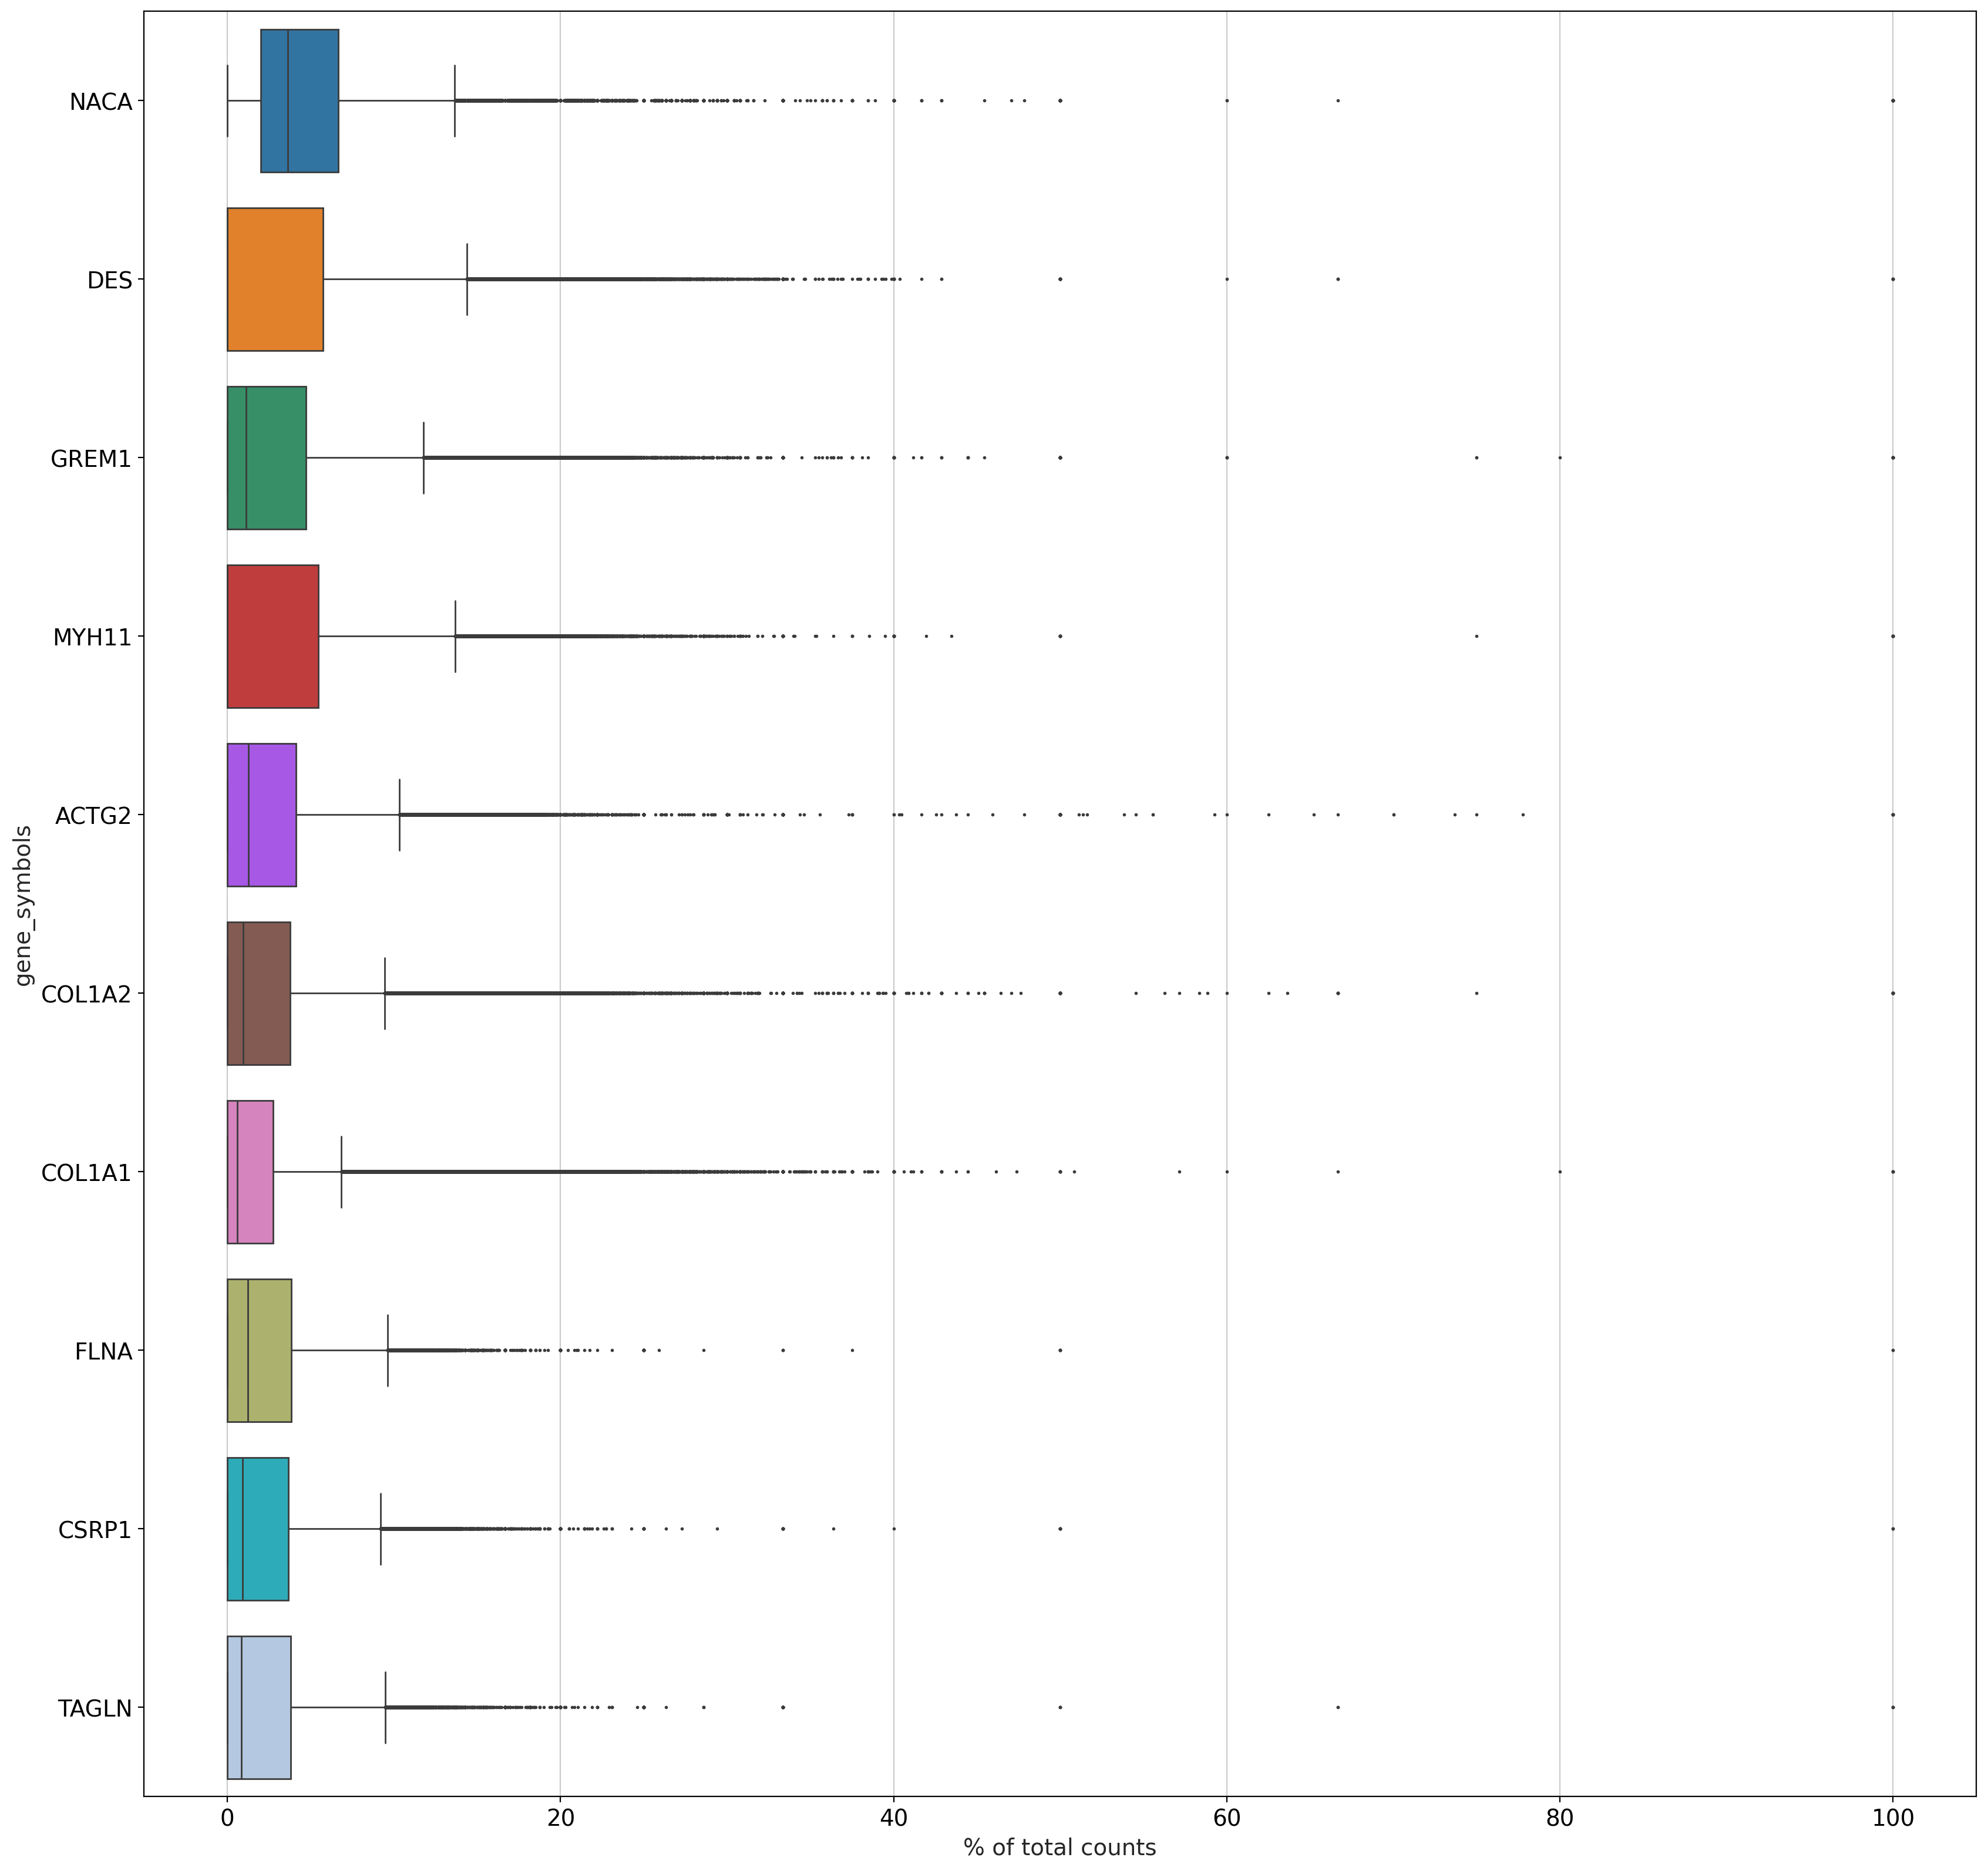

dsfasfda AnnData object with n_obs × n_vars = 561965 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Location', 'Stricture', 'Inflamed', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts'


Cell Counts: Initial


Observations: 561965



Gene Counts: Initial

Empty DataFrame
Columns: [gene_symbols, gene_ids, feature_types, geno

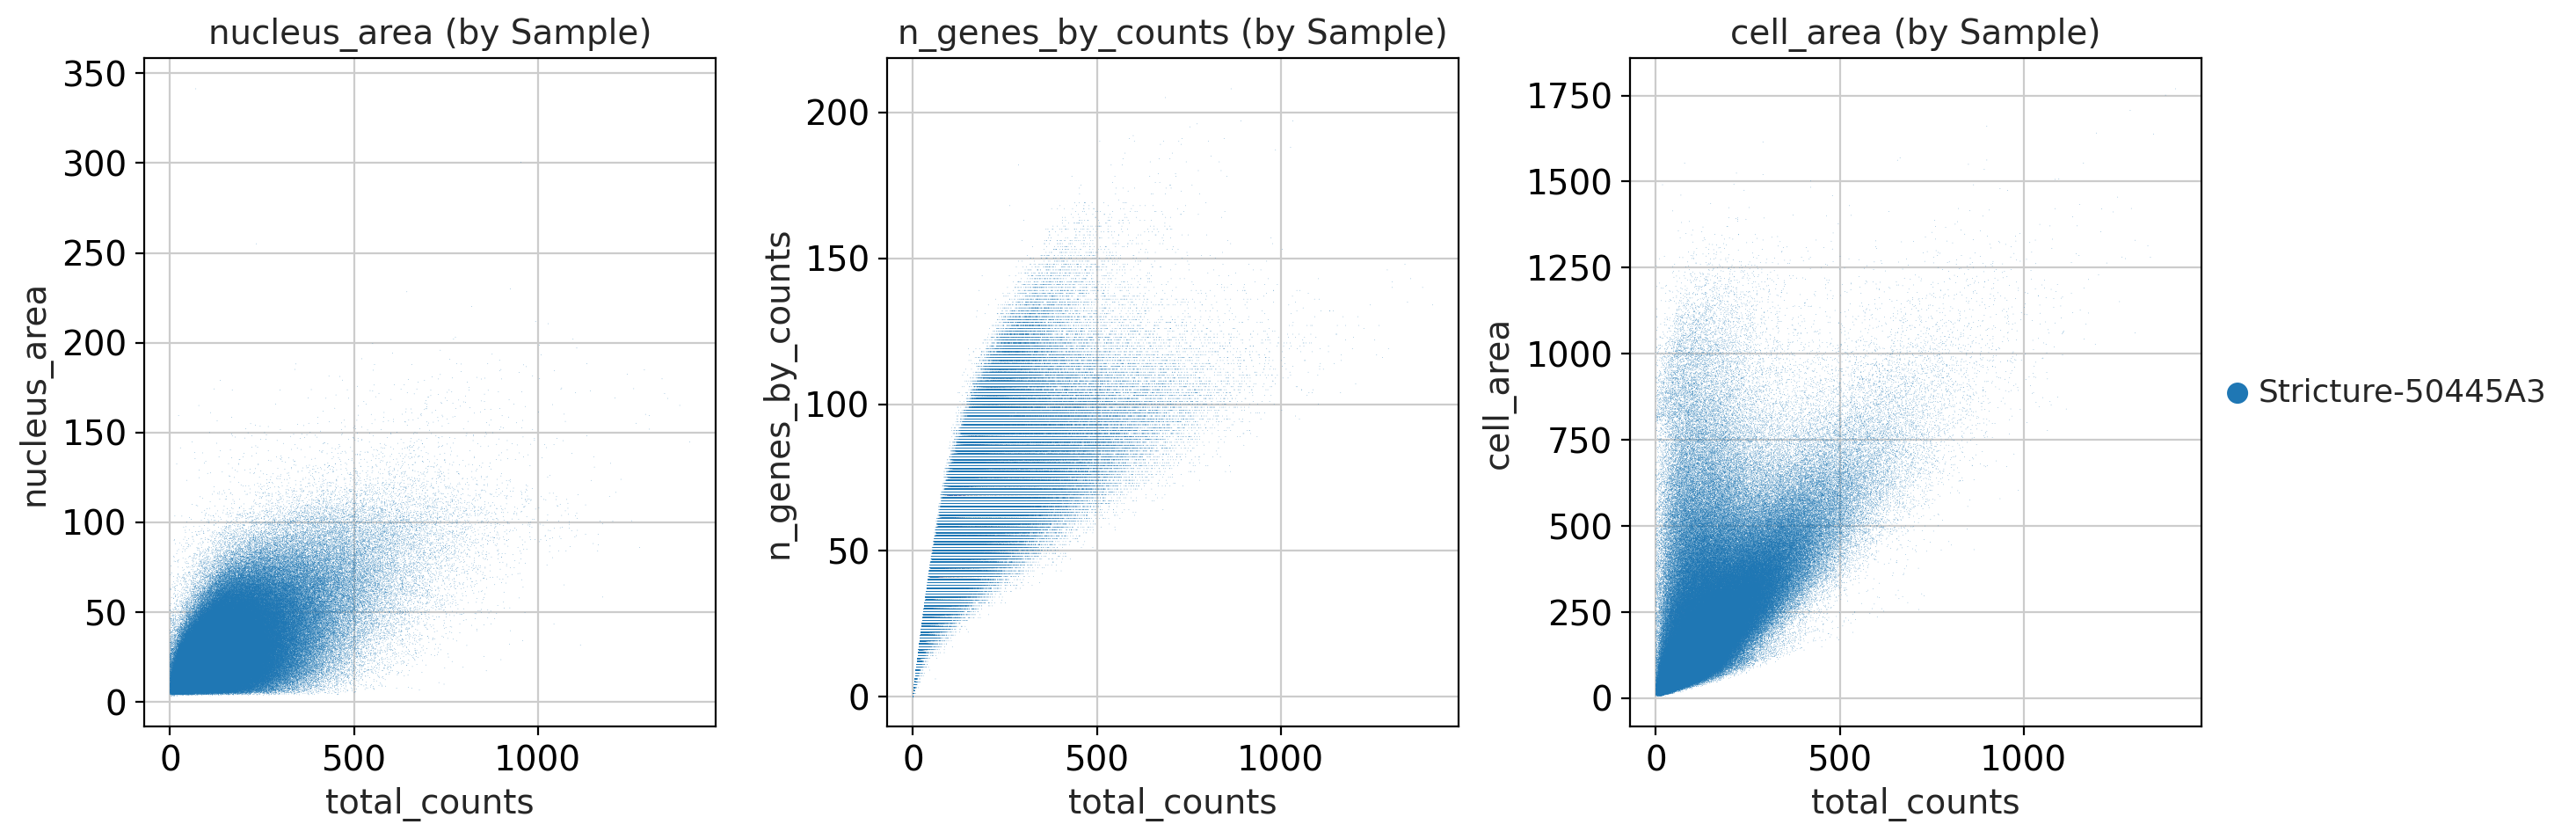


<<< FILTERING CELLS (TOO FEW GENES) & GENES (TOO FEW CELLS) >>>
dsfasfda AnnData object with n_obs × n_vars = 505534 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Location', 'Stricture', 'Inflamed', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts'

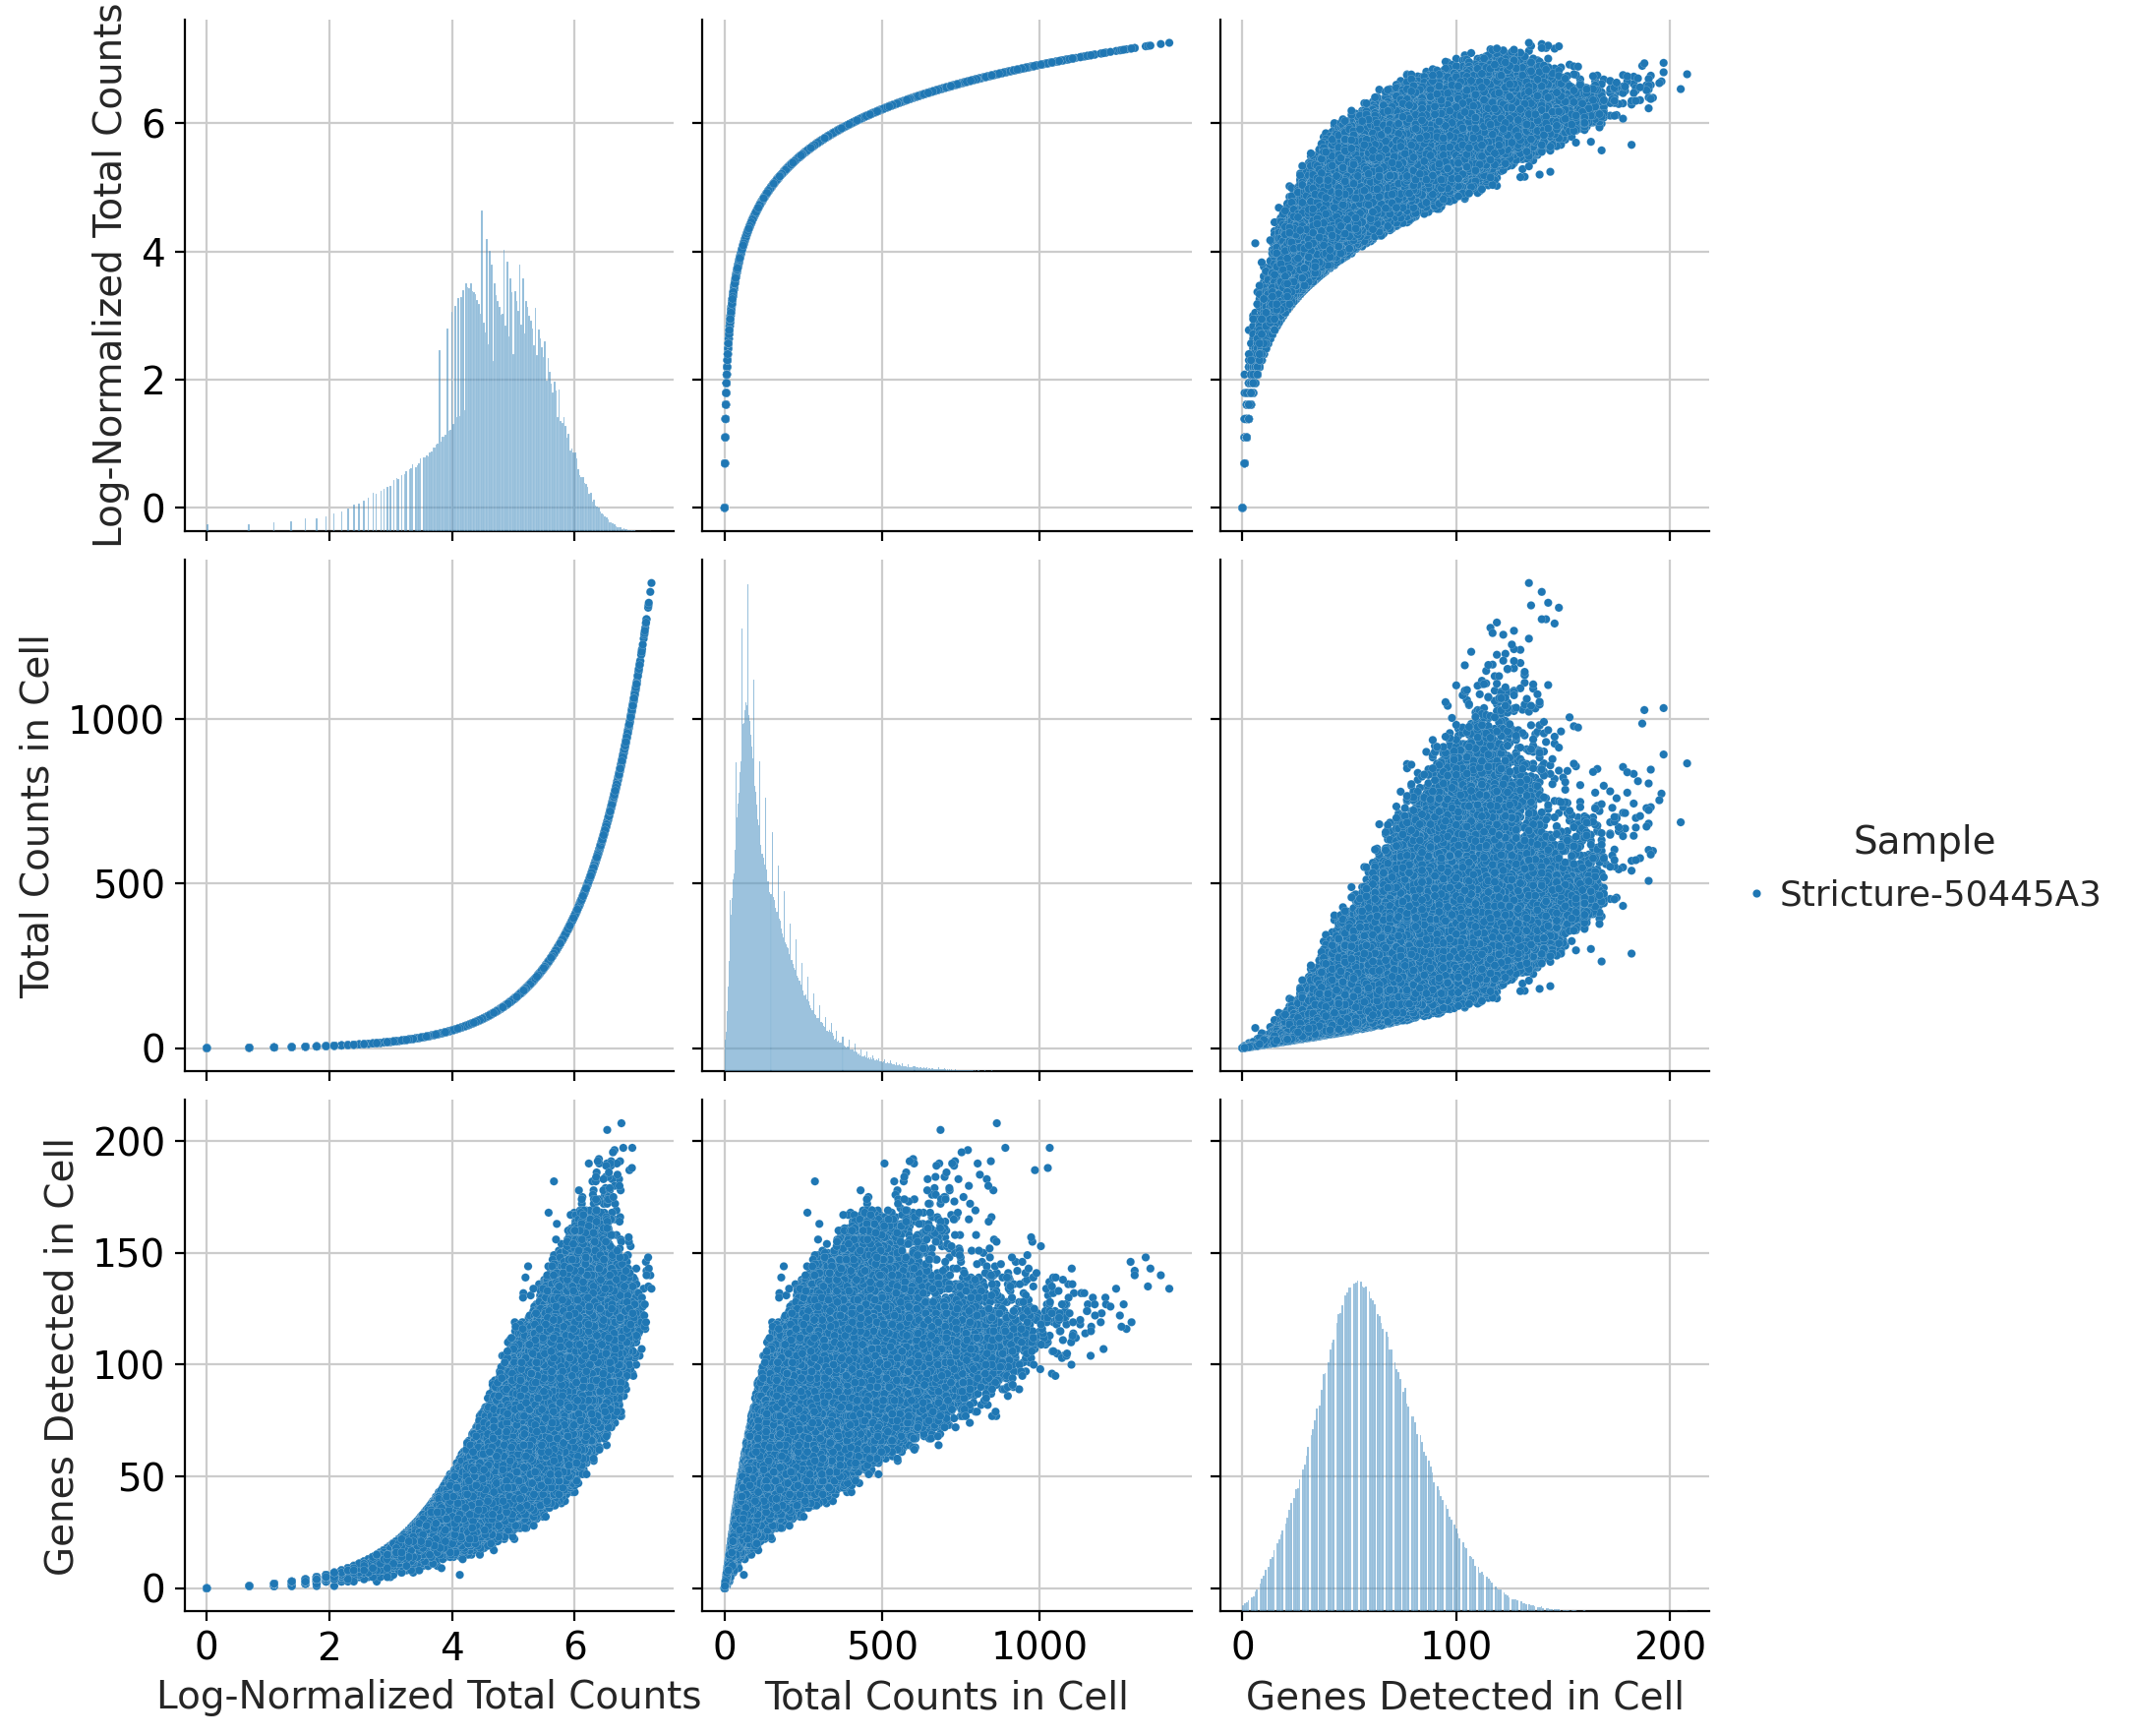

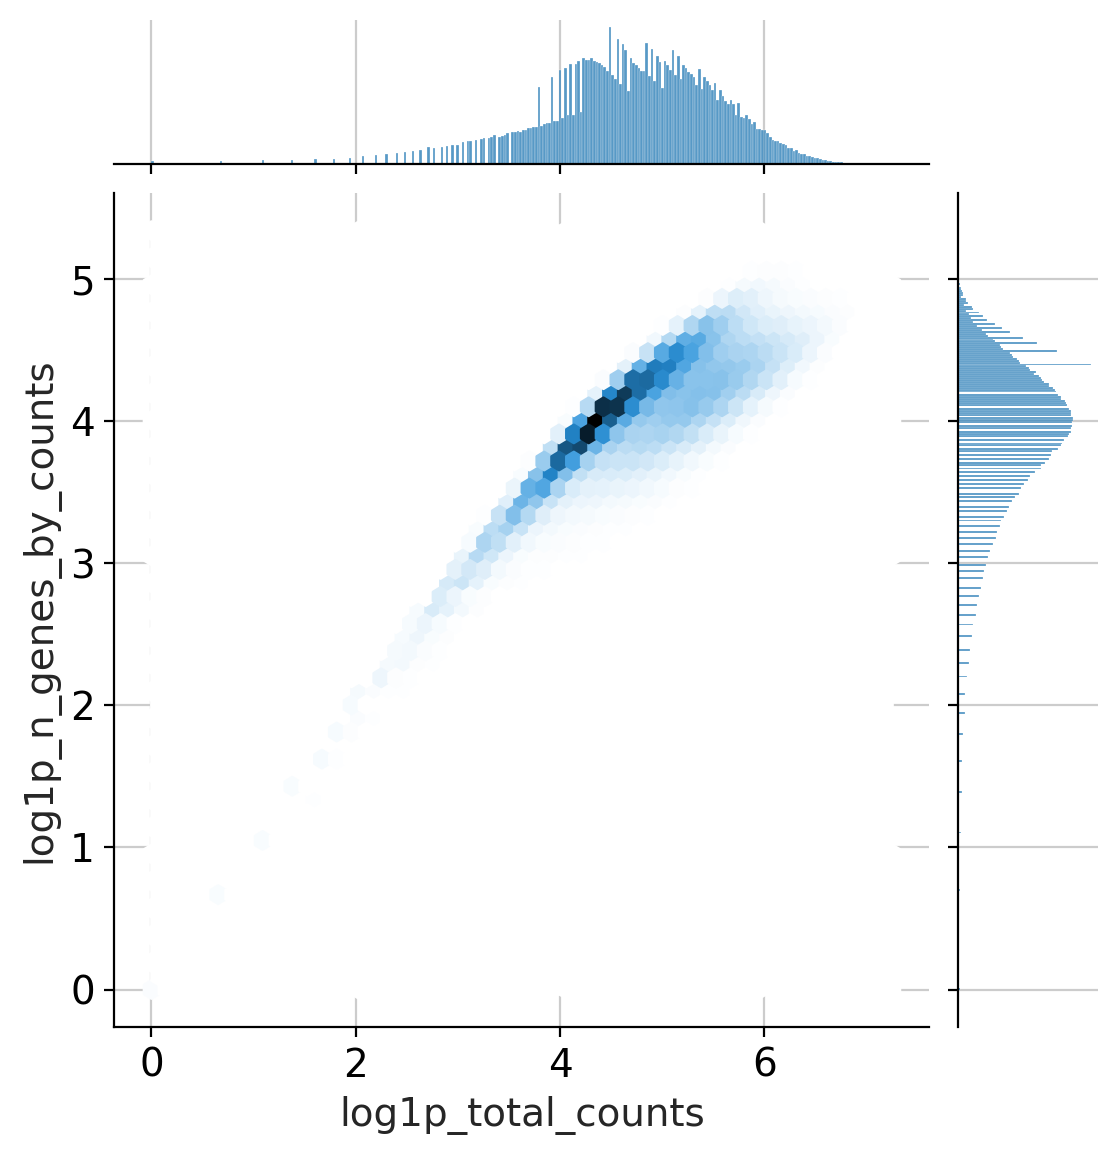

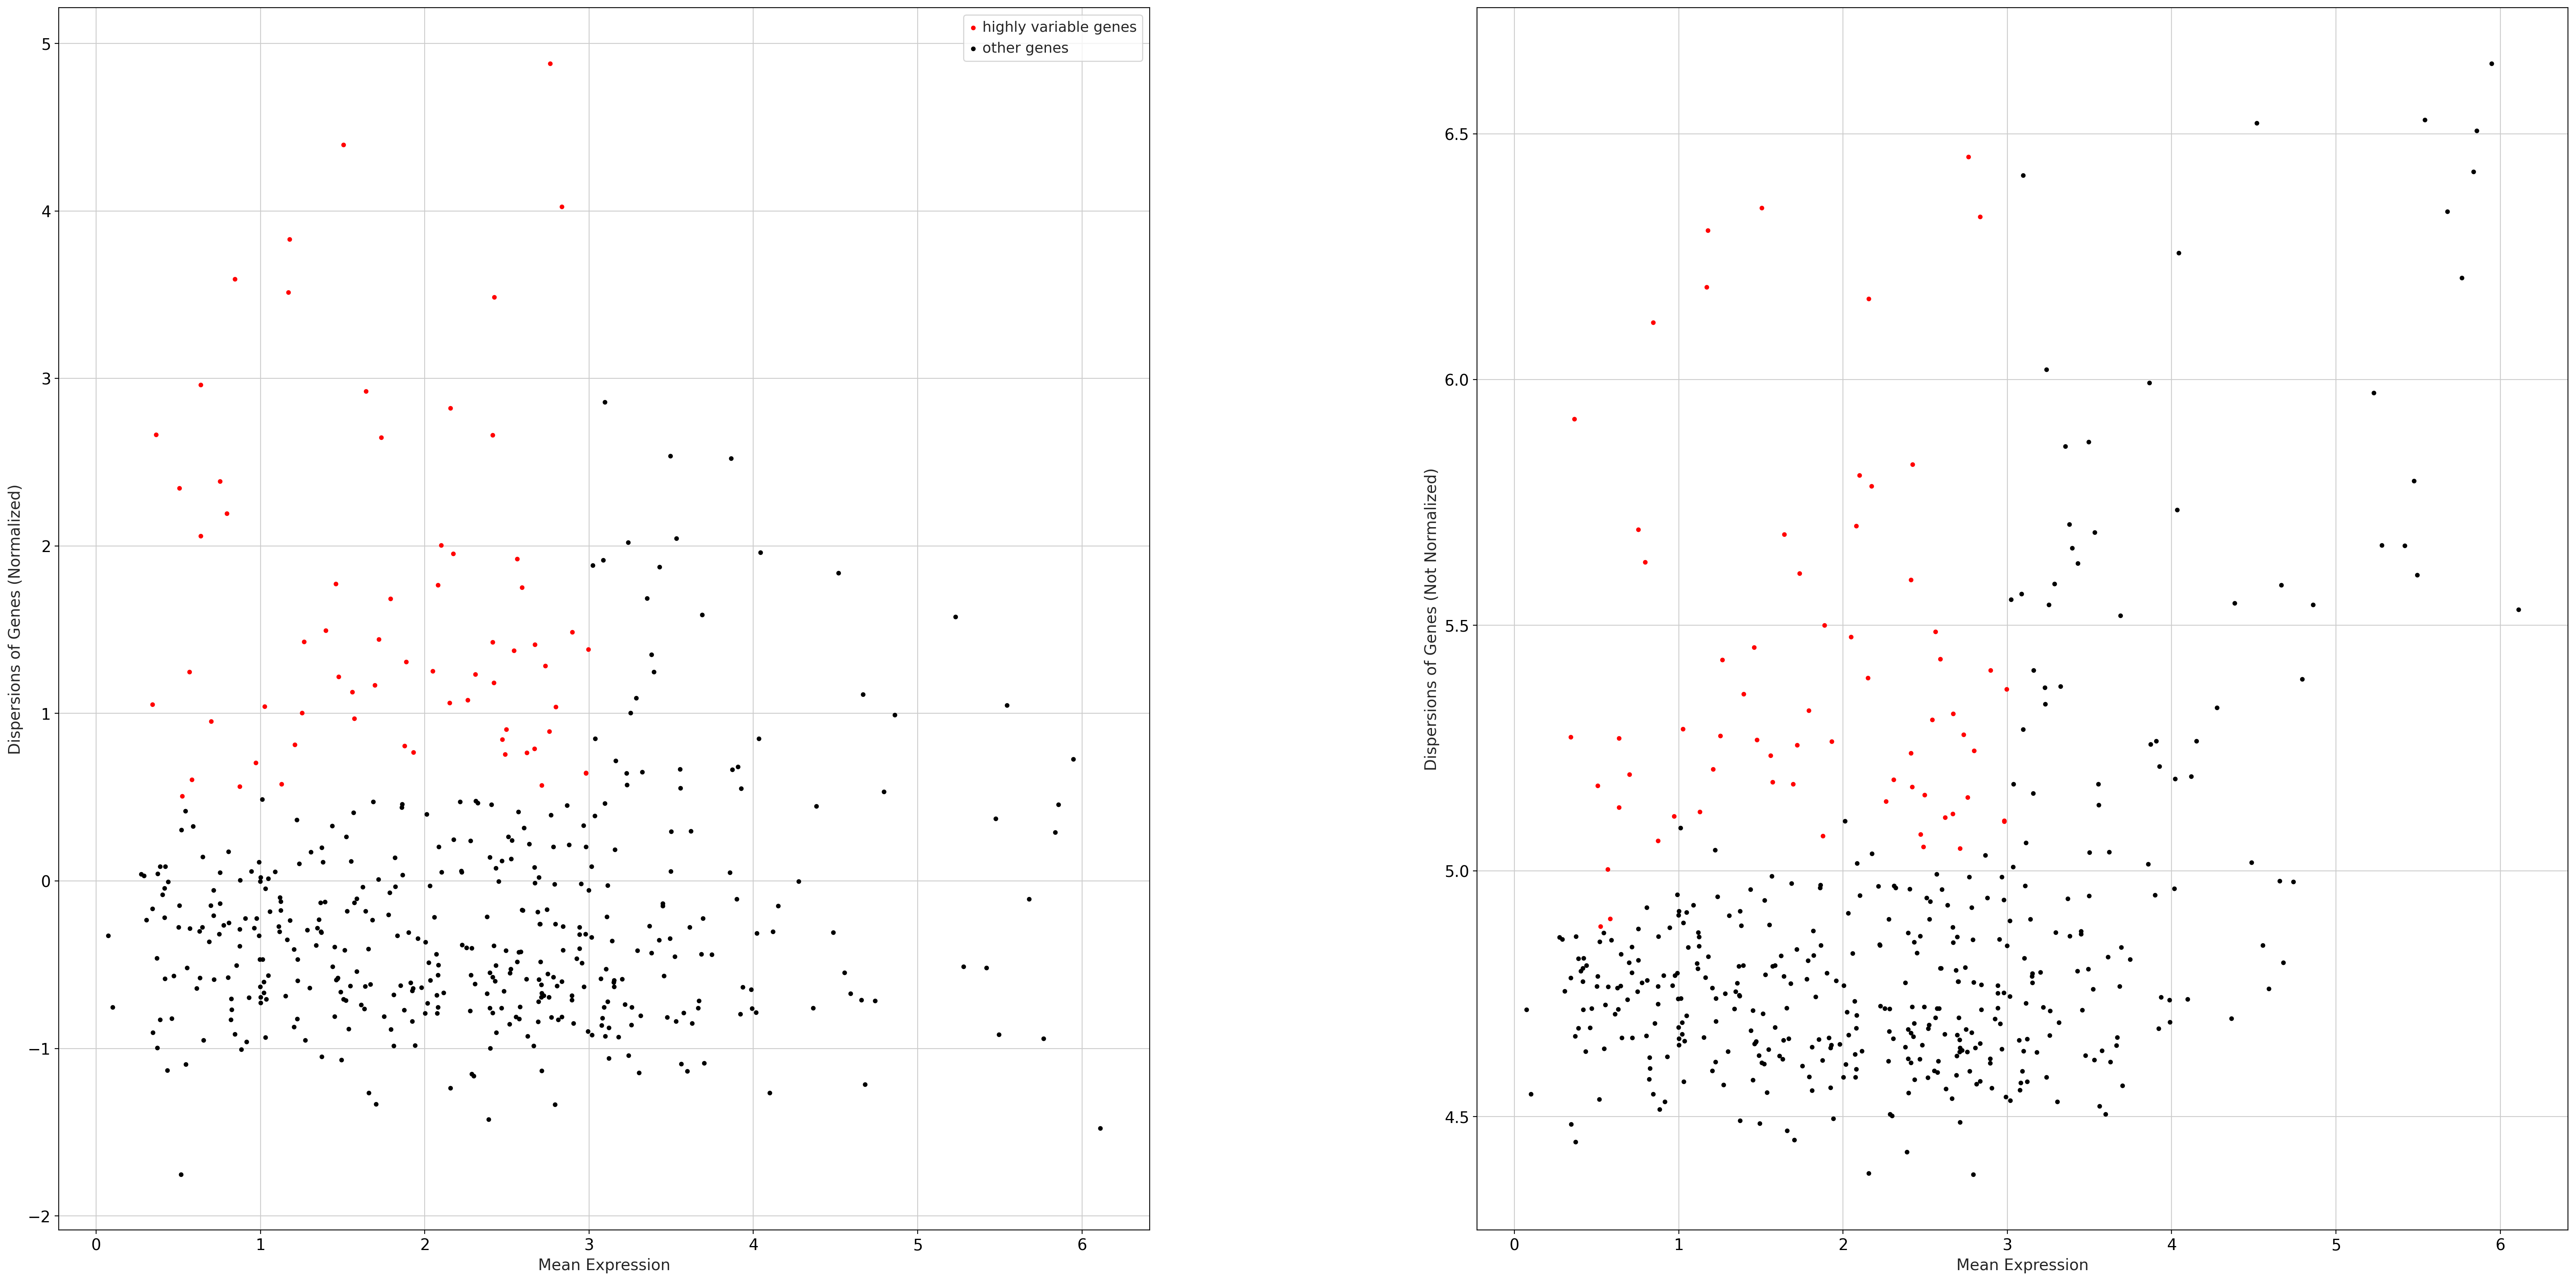


<<< NORMALIZING RAW GENE EXPRESSION >>>

	*** Scaling gene expression...

	*** Clipping maximum GEX SD to 10...

	*** Scaling => `.X` & scaled layer...
dsfasfda AnnData object with n_obs × n_vars = 477140 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Location', 'Stricture', 'Inflamed', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo'

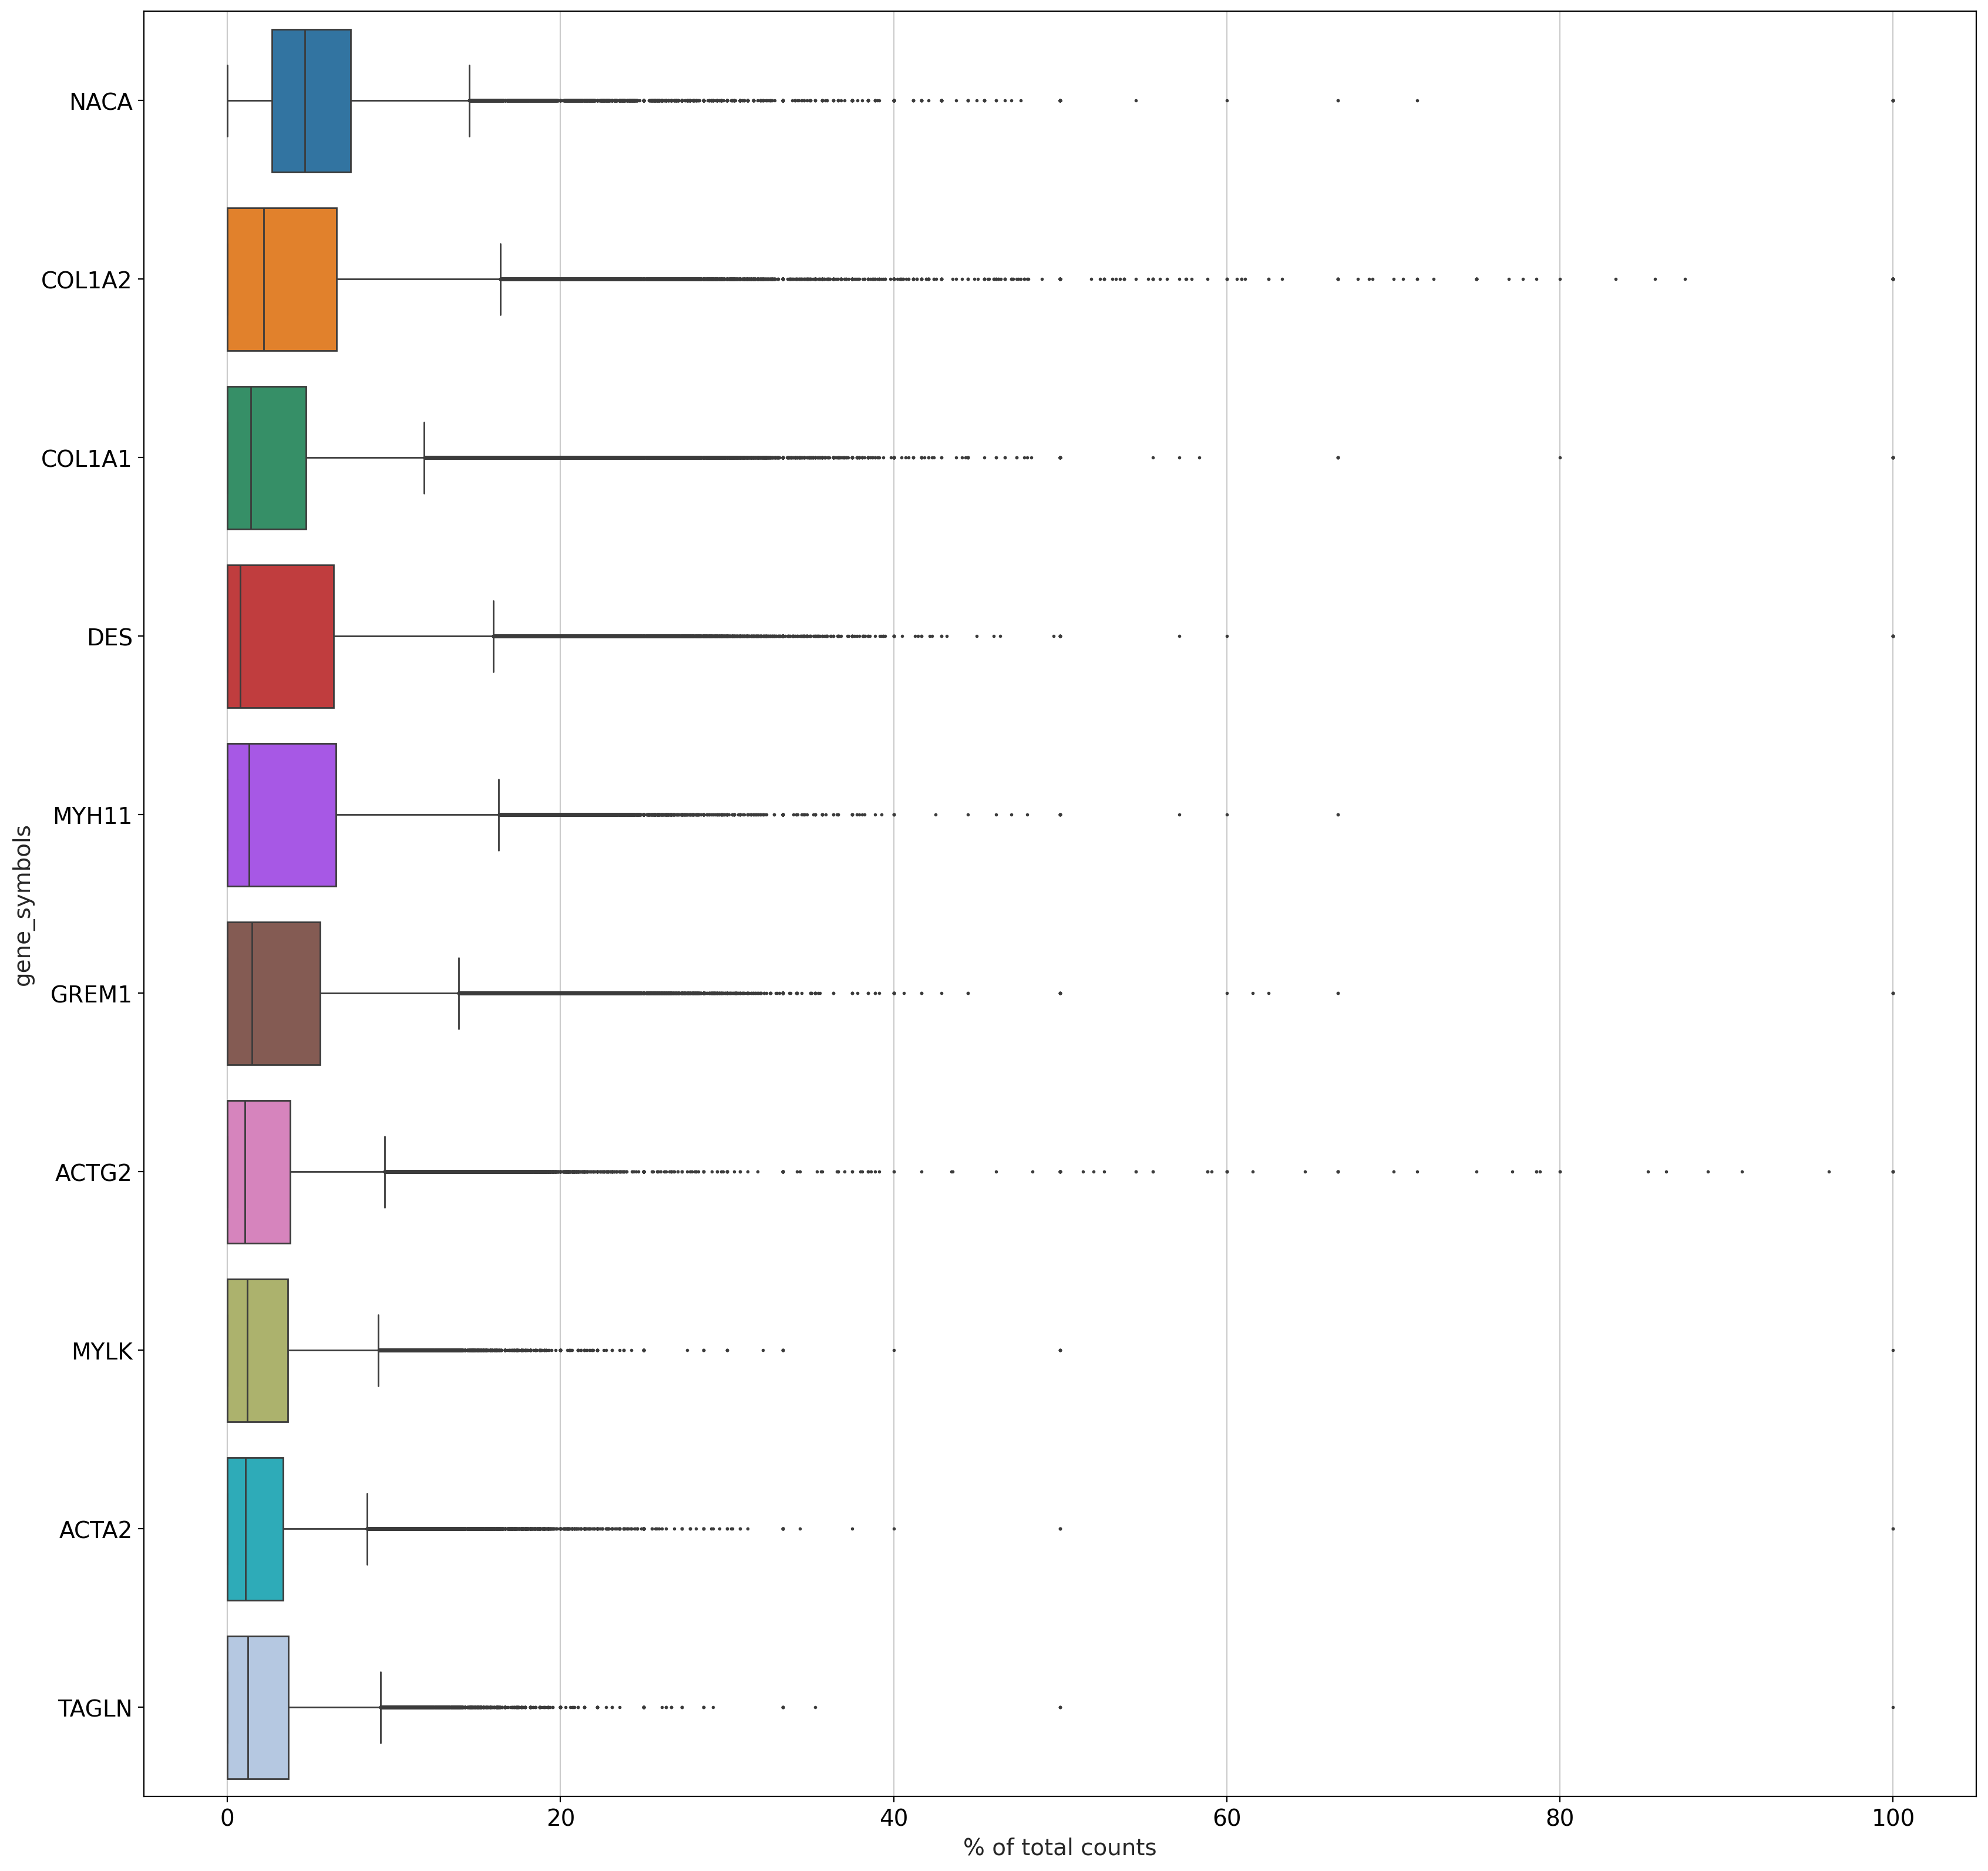

dsfasfda AnnData object with n_obs × n_vars = 610082 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Location', 'Stricture', 'Inflamed', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts'


Cell Counts: Initial


Observations: 610082



Gene Counts: Initial

Empty DataFrame
Columns: [gene_symbols, gene_ids, feature_types, geno

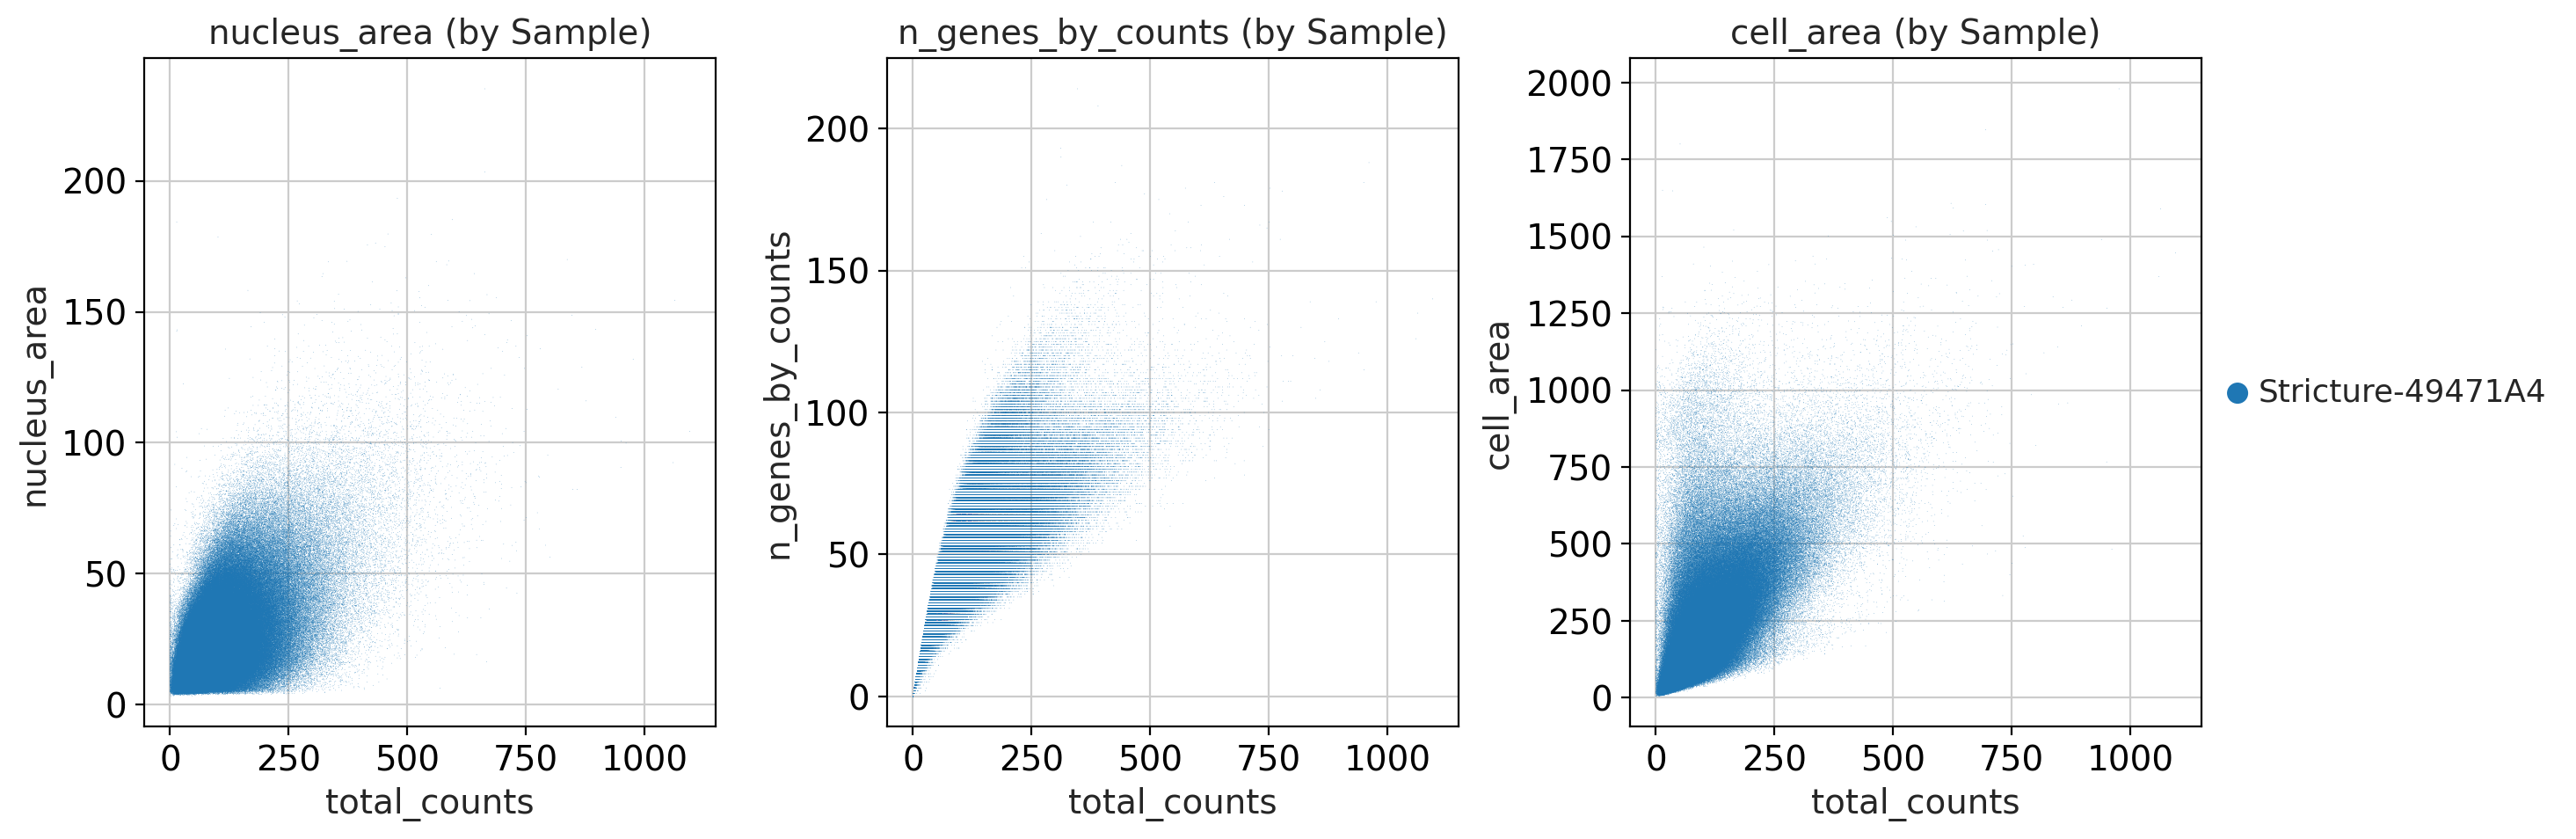


<<< FILTERING CELLS (TOO FEW GENES) & GENES (TOO FEW CELLS) >>>
dsfasfda AnnData object with n_obs × n_vars = 510389 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Location', 'Stricture', 'Inflamed', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts'

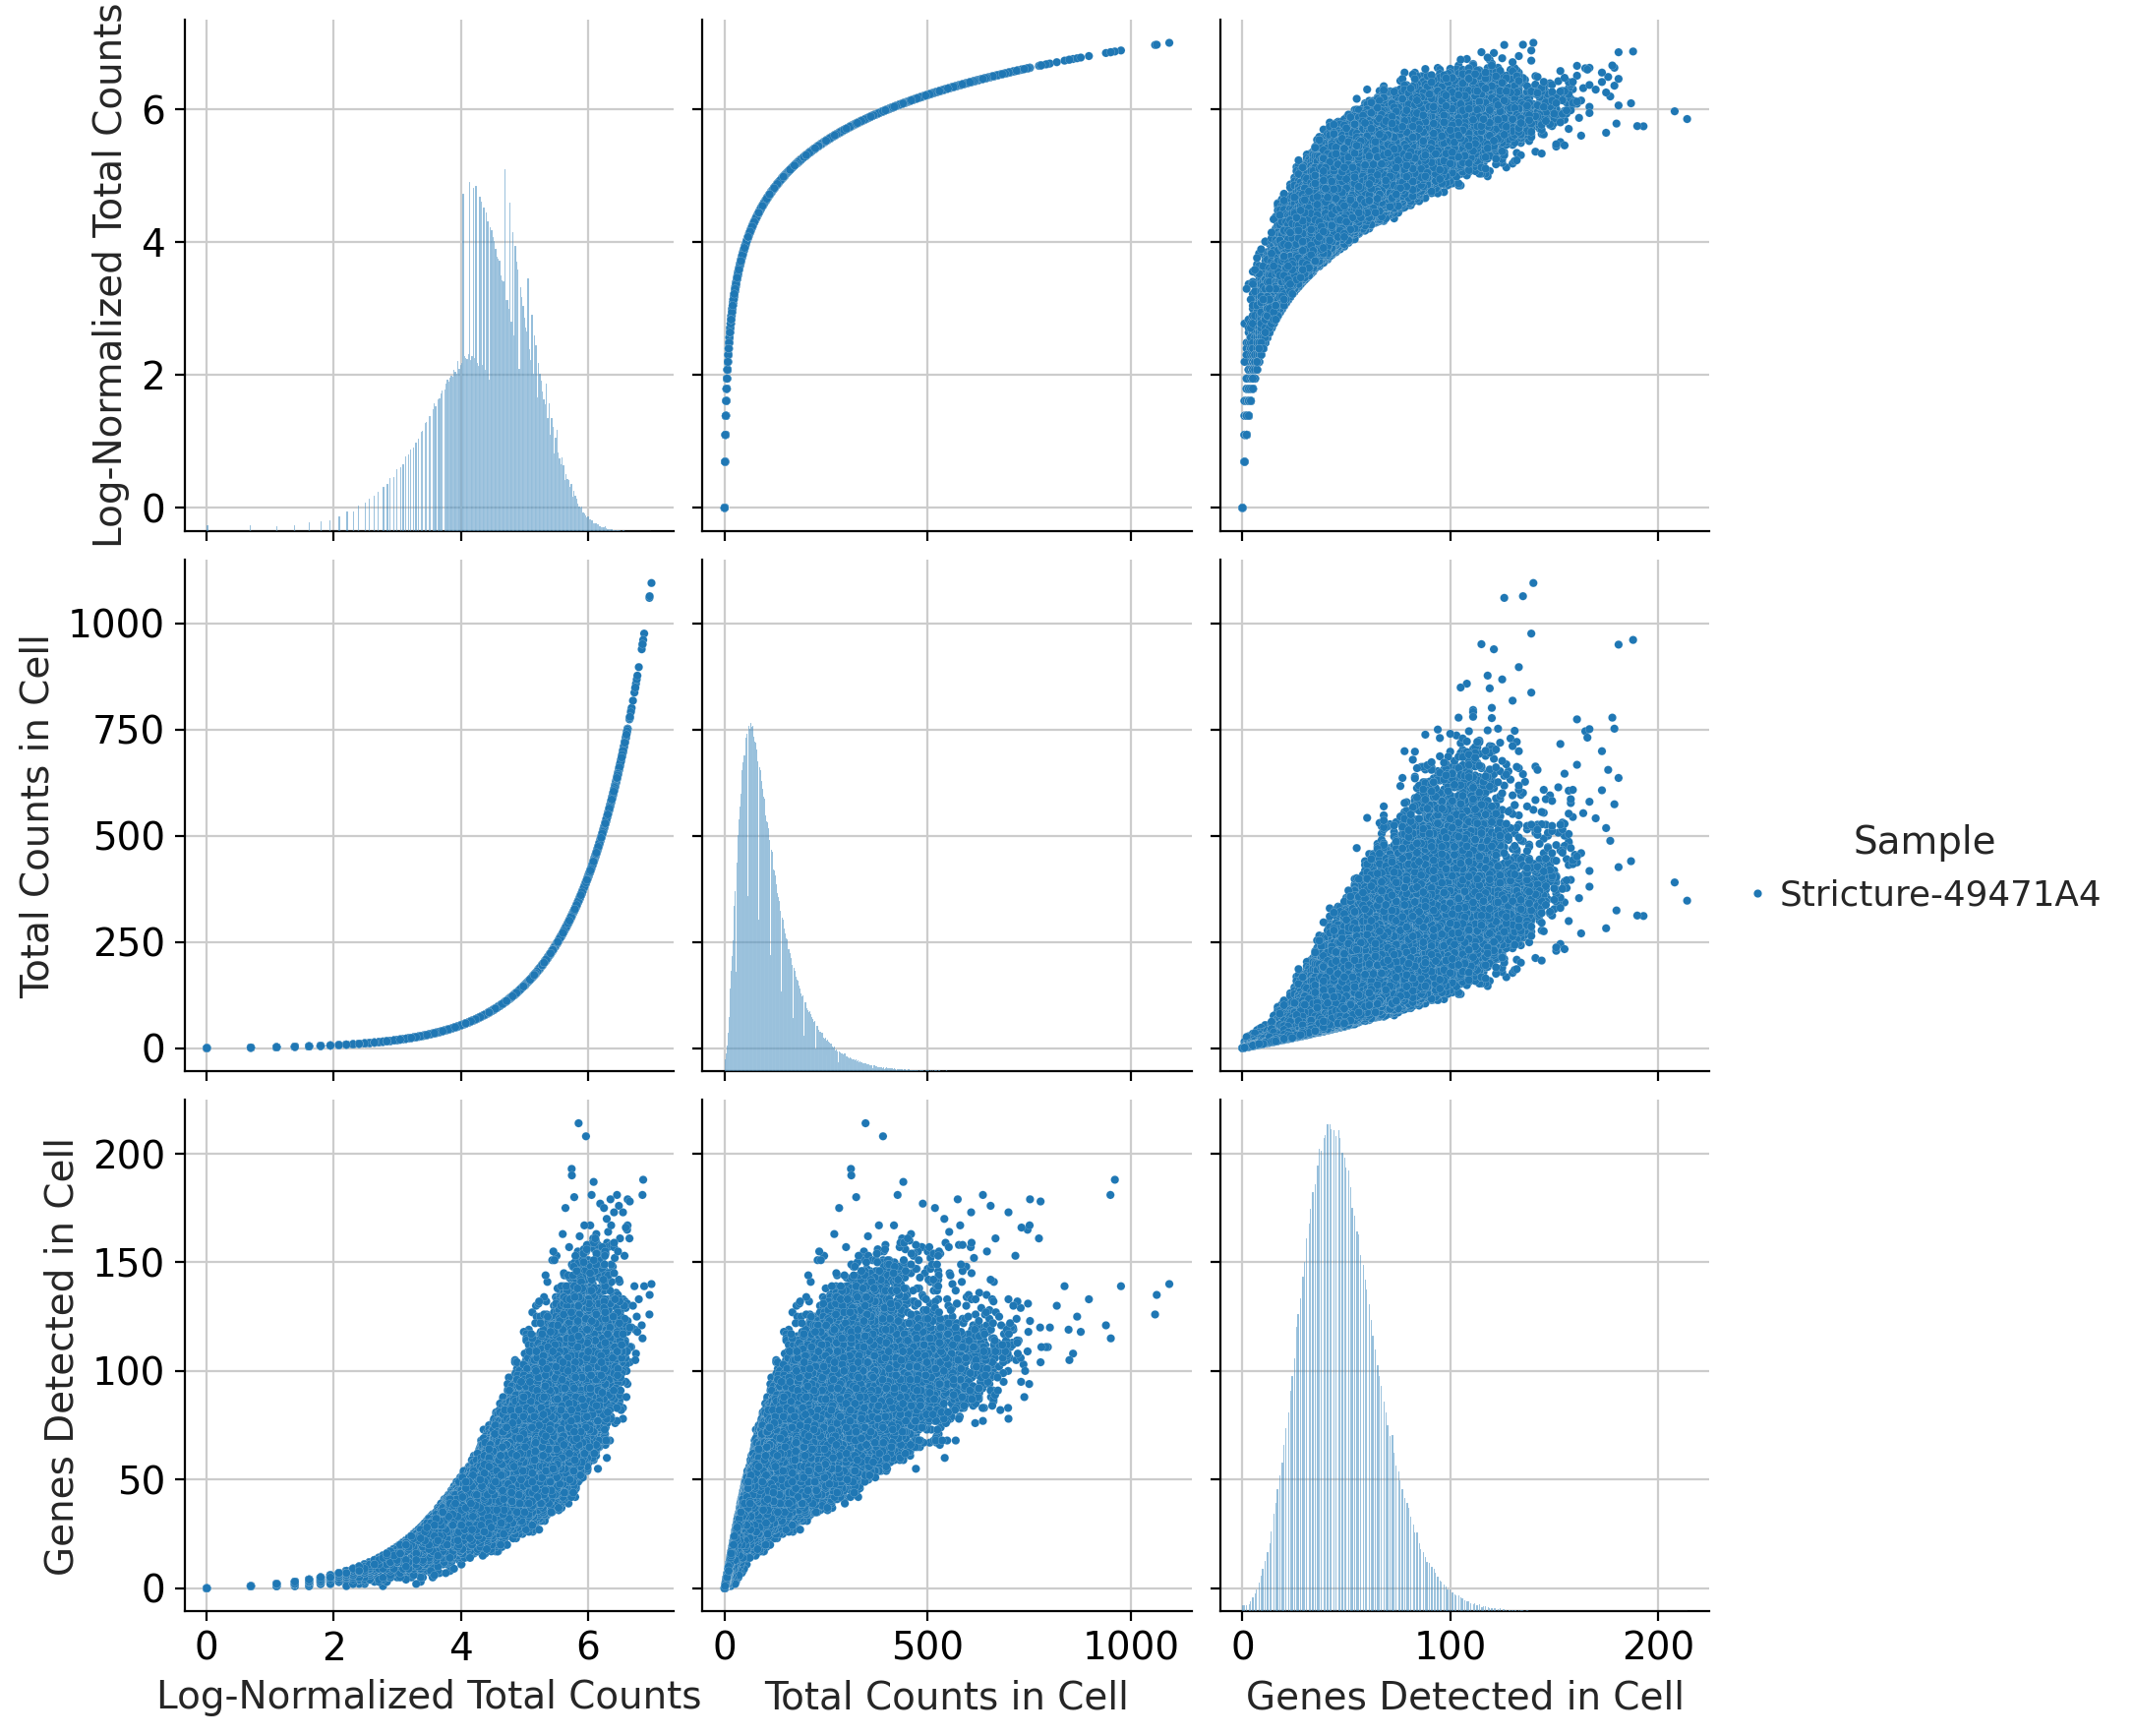

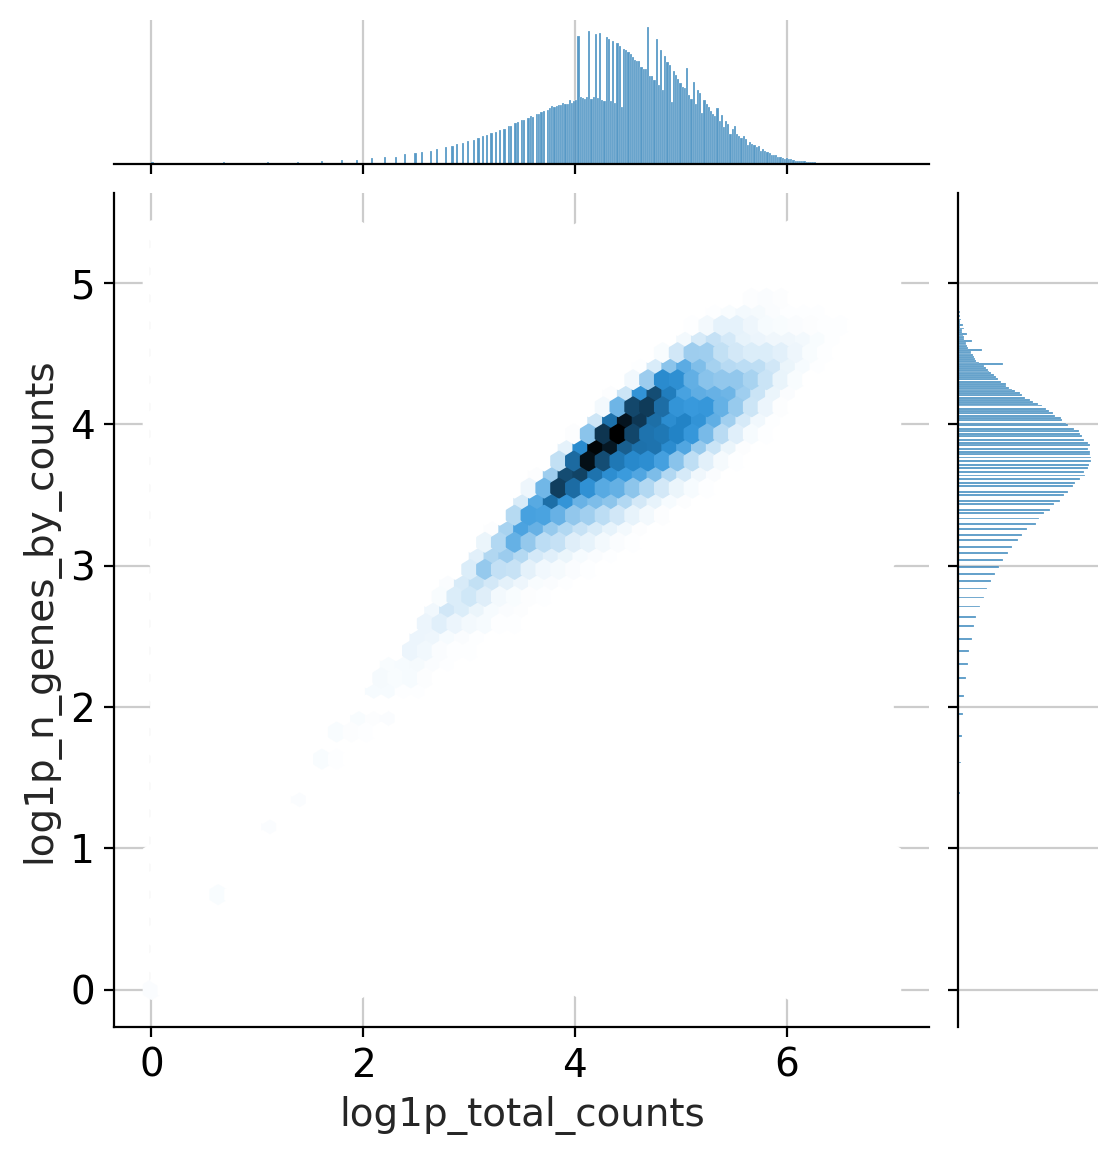

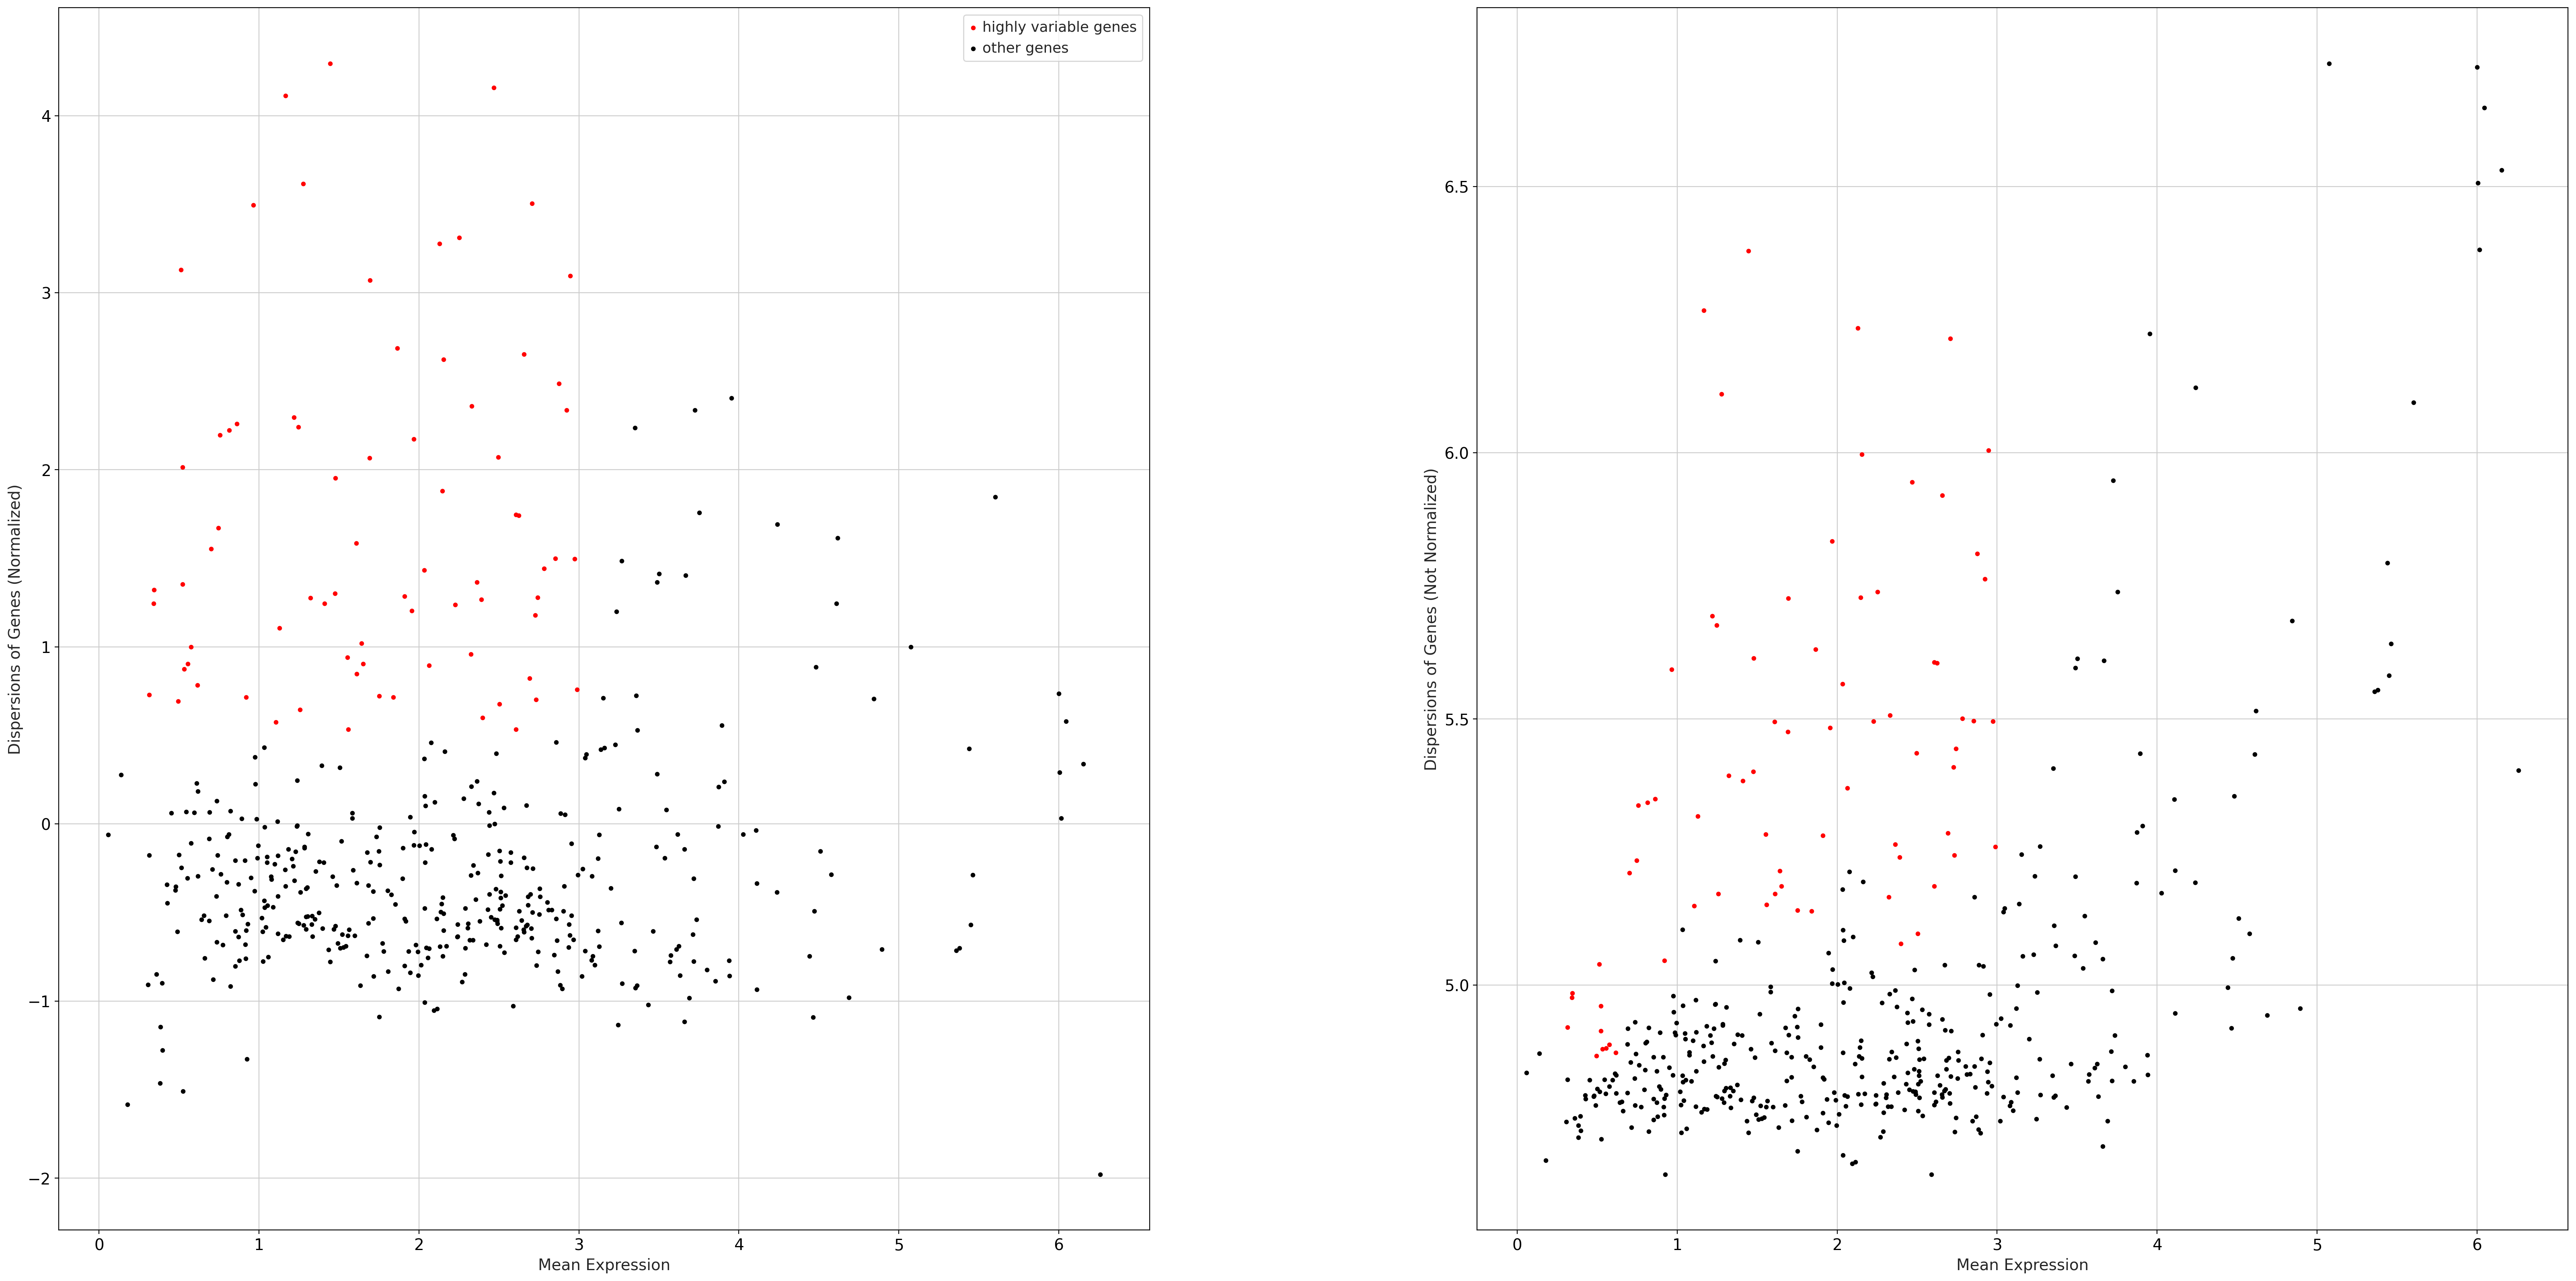


<<< NORMALIZING RAW GENE EXPRESSION >>>

	*** Scaling gene expression...

	*** Clipping maximum GEX SD to 10...

	*** Scaling => `.X` & scaled layer...
dsfasfda AnnData object with n_obs × n_vars = 477727 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Location', 'Stricture', 'Inflamed', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo'

In [4]:
%%time

# Perform Pre-Processing
if reload is False:
    print(kws_pp)
    for s in selves:
        _ = s.preprocess(**kws_pp, figsize=(20, 20))

# Check Remaining Genes
for s in selves:
    _ = s.read_panel(directory=str(metadata.loc[s._library_id][col_path]))

## Clustering

In [5]:
%%time

# Cluster & Write Objects
for i, s in enumerate(selves):
    if reload is False:
        _ = s.cluster(**kws_cluster, out_file=out_files[i])  # cluster
        _ = s.find_markers(n_genes=10, out_file=file_mk[i],
                           col_cell_type="leiden", kws_plot=False)  # markers
        _ = s.plot_spatial(color="leiden")



Un-used Keyword Arguments: {'assay': None}


<<< PERFORMING PCA >>>
{'use_highly_variable': False, 'n_comps': 50, 'random_state': 0}



<<< COMPUTING NEIGHBORHOOD GRAPH >>>
{'random_state': 0, 'n_pcs': 50}



<<< EMBEDDING UMAP >>>
{'random_state': 0, 'min_dist': 0.3, 'method': 'umap'}



<<< CLUSTERING WITH LEIDEN METHOD >>>
Resolution=0.5


## Annotation 

In [ ]:
%%time

# col = "Annotation_GEX"  # for method 2
col = None  # skip method 2
if reload is False:
    for i, s in enumerate(selves):
        _ = s.annotate_clusters(file_ann, col_cell_type="leiden",
                                col_annotation=col_cell_type,
                                out_file=out_files[i])  # annotate & write
        if col:
            _ = s.annotate_clusters(file_ann, col_annotation=col,
                                    renaming=True, method="GEX")  # method 2
        # s._columns["col_cell_type"] = col + "_GEX"

# Manual Annotations
# annots = {
#     0: {"0": "Myofibroblast", "1": "Goblet", "2": "Cycling B",
#         "3": "Fibroblast", "4": "Endothelial",
#         # "5": "Goblet",
#         "5": "Epithelial",
#         # "6": "Goblet (Best, 2+?)", "7": "Myeloid (Macrophage? DC?)",
#         "6": "Epithelial", "7": "Myeloid",
#         "8": "Mesenchymal-Fibrolastic-Stromal 3",
#         "9": "Plasma", "10": "T Cell", "11": "Macrophage, LYVE1+",
#         "12": "Pericyte", "13": "Endothelial Lymphatic",
#         "14": "Mast", "15": "Mesenchymal-Myocytic-Myofibroblast"},
#     1: {"0": "Contractile Pericyte",
#         "1": "Mesenchymal-Fibroblastic-Stromal 1,3",
#         "2": "Endothelial", "3": "B Cell", "4": "T Cell",
#         "5": "Mesenchymal-Fibroblastic-Stromal 1", "6": "Myofibroblast",
#         "7": "Epithelial", "8": "Plasma", "9": "Macrophage",
#         "10": "Myeloid", "11": "Mast",
#         "12": "Lymphatic Endothelial", "13": "Neural"},
#     2: {"0": "B Cell", "1": "Mesenchymal", "2": "T/NK Cell",
#         "3": "Mesenchymal-Fibroblastic-Transitional Stromal 1",
#         "4": "Smooth Muscle", "5": "Endothelial", "6": "Macrophage",
#         "7": "Lymphatic Endothelial",
#         "8": "Smooth Muscle/Pericyte/Myofibroblast?",
#         "9": "IgA Plasma", "10": "Cycling B Cell",
#         "11": "Epithelial-Enterocyte-Tuft?", "12": "Neural"}
# }

# ONLY FOR RESOLUTION = 0.75,
# JUST CELL TYPE GENES USED IN CLUSTERING,
# MIN_DIST = 0.80
# rename_annotations = {
#     str("Activated CD4 T_Branch A4 (IN)_CLP_Colonocyte_Contractile Pericyte"
#         " (PLN+)_D Cells (SST+)_FCRL4+ Memory B_FDC_Fetal Arterial EC_Glia"
#         " 2 (ELN+)_ILCP_Lymphoid DC_Macrophages_Mast Cell_Microfold Cell_N"
#         " Cells (NTS+)_NK Cell_Pericyte_SELL+ CD8 T_Stromal 1 (ADAMDEC1+)"
#         "_TRGV2 Gdt_cDC2"): "Mixed Immune",
#     str("Activated CD4 T_BEST2+ Goblet Cell_Branch A4 (IN)_CLP_Colonocyte_"
#         "Contractile Pericyte (PLN+)_D Cells (SST+)_FCRL4+ Memory B_FDC"
#         "_Fetal Arterial EC_Glia 2 (ELN+)_ILCP_Immature B_Macrophages"
#         "_Microfold Cell_NK Cell_Pericyte_SELL+ CD8 T_Stromal 1 (ADAMDEC1+)"
#         "_TRGV2 Gdt_cDC2_mLTo"): "Immune (Lymphoid?)",
#     str("Activated CD4 T_Branch A4 (IN)_CLP_Colonocyte_Contractile Pericyte"
#         " (PLN+)_D Cells (SST+)_FCRL4+ Memory B_FDC_Fetal Arterial EC_Glia"
#         " 2 (ELN+)_ILCP_Lymphoid DC_Macrophages_Mast Cell_Microfold Cell_N"
#         " Cells (NTS+)_NK Cell_Pericyte_SELL+ CD8 T_Stromal 1 (ADAMDEC1+)_"
#         "TRGV2 Gdt_cDC2"): "Mixed Immune",
#     str("Activated CD4 T_Branch A4 (IN)_CD8 Tmem_CLP_FCRL4+ Memory B_FDC_"
#         "Fetal Arterial EC_Glia 2 (ELN+)_ILCP_Lti-like NCR+ ILC3_Lymphoid"
#         " DC_Macrophages_Mast Cell_Megakaryocyte_Microfold Cell_NK Cell_"
#         "Pericyte_SELL+ CD8 T_TRGV2 Gdt_mLTo"): "Mixed Immune",
#     str("Activated CD4 T_Branch A4 (IN)_CLP_Distal Progenitor_FCRL4+ Memory"
#         " B_FDC_Fetal Arterial EC_Glia 2 (ELN+)_ILC3_Lti-like NCR+ ILC3_"
#         "Macrophages_Mast Cell_Microfold Cell_Monocytes_Pericyte_Proximal "
#         "Progenitor_SELL+ CD8 T_Stromal 1 (ADAMDEC1+)_"
#         "TRGV2 Gdt"): "B_T_ILC",
#     str("Angiogenic Pericyte_Immature Pericyte_LYVE1+ Macrophage"
#         ): "Pericyte_Macrophage"}

rename_annotations = None

# Rename Annotations
if rename_annotations is not None:
    for i, s in enumerate(selves):
        s.rna.obs.loc[:, f"{col}_Auto"] = s.rna.obs[col].copy()
        s.rna.obs.loc[:, col] = s.rna.obs[col].replace(
            rename_annotations if isinstance(
                rename_annotations, dict) else rename_annotations[i])
    [print(list(s.rna.obs[col].unique())) for s in selves]

# Plot Spatial
for s in selves:
    s.plot_spatial(title=s._library_id, color=col_cell_type)
    if col:
        s.plot_spatial(title=s._library_id, color=col)

## Annotation by Imputation (Tangram)

In [ ]:
adata_sc = sc.read(file_sc)  # read whole transcriptome data for imputation
for i, s in enumerate(selves):
    _ = s.impute(
        adata_sc.copy(), col_cell_type=col_cell_type_sc,
        # mode="cells",
        mode="clusters",
        markers=None,  # use all overlap
        # markers=200,
        plot=False, plot_density=False, plot_genes=None,
        col_annotation=col_tangram,
        out_file=os.path.dirname(out_files[i]) if out_files else None)
        # adata_sp_new, sdata, adata_sc_n, ad_map, df_compare, fig = out

## Write Xenium Explorer Files

In [ ]:
for c in ["leiden", col_cell_type, col, col_tangram]):
    for i, s in enumerate(selves):
        if c in s.rna.obs:
            s.write_clusters(out_dir, file_prefix=out_files[i],
                             col_cell_type=c, overwrite=True, n_top=None)

## Marker Plots (Additional)

In [ ]:
_ = self.plot(kind="heat", swap_axes=True, vmax=10,
              marker_genes_dict=marker_genes_dict, layer="counts")

## Concatenate AnnData

In [ ]:
hue = selves[0]._columns["col_sample_id"]
ids = [str(s.rna.obs[hue].iloc[0]) for s in selves]
adata = AnnData.concatenate(
    *[x.rna for x in selves], join="outer", batch_key=hue,
    batch_categories=ids, index_unique=None, uns_merge="unique")

## Preliminary Exploration

In [ ]:
# for s in selves:
#     _ = s.read_panel(directory=metadata[s._library_id]["file_path"])
# for s in selves:
#     s.plot_umap(color=genes + [self._columns["col_cell_type"]],
#                 layer="scaled", cmap="coolwarm", vcenter=0)
cct = selves[0]._columns["col_cell_type"]
for g in [["CDKN1A", "CDKN2A", "TP53", "PLAUR", "PTGER4", "FTL", "IL6ST"],
          ["CSF2RB", "CSF2RA", "IL7R", "TBX21", "KLRB1", "CCL5", "HSP90AA1",
           "RORC", "IL23R", "KIT", "CCL20", "TCF7", "LTB", "IL22", "IFNG"],
          ["PDGFRA", "IL6ST", "PTPN1", "IFNG"]]:
    ggg = list(set(g).intersection(adata.var_names))
    cr.pl.plot_cat_split(adata, col_inflamed, col_cell_type=cct,
                         genes=ggg, kind="box")
    cr.pl.plot_cat_split(adata, col_inflamed, col_cell_type=cct,
                         genes=ggg, columns=col_stricture, kind="box")

# Analyses

## Centrality Scores

In [ ]:
%%time

for s in selves:
    s.calculate_centrality(n_jobs=sc.settings.n_jobs)

## Cell Type Co-Occurrence

In [ ]:
%%time

for s in selves:
    _ = s.find_cooccurrence(figsize=(60, 20), kws_plot=dict(wspace=3))

## Neighborhood Enrichment Analysis

In [ ]:
%%time

for s in selves:
    _ = s.calculate_neighborhood(figsize=(60, 30))

## Spatial Clustering

In [ ]:
for s in selves:
    _ = s.cluster_spatial()

## Spatially-Variable Genes

In [ ]:
%%time

kws = dict(kws_plot=dict(legend_fontsize="large"), figsize=(15, 15))
for s in selves:
    _ = s.find_svgs(genes=genes, method="moran", n_perms=10, **kws)

## Receptor-Ligand Interactions

In [ ]:
%%time

for s in selves:
    # kss, ktt = [s.rna.obs[s._columns["col_cell_type"]].unique(
    #     ).to_list()[i:(4 + i)] for i in [1, 2]]
    kss, ktt = None, None
    _ = s.calculate_receptor_ligand(
        col_condition=False, p_threshold=0.01, remove_ns=True,
        figsize=(30, 10), top_n=25, key_sources=kss, key_targets=ktt)
    # s.calculate_receptor_ligand_spatial()

## Cell Type Composition 

In [ ]:
for s in selves:
    s.run_composition_analysis()

## GEX

In [ ]:
for s in selves:
    s.plot_spatial(color=["TNF", "IL23", col_cell_type])

In [ ]:
_ = self.calculate_spatial_distance("LTi-like NCR+ ILC3", genes="CSF2RB")

In [ ]:
adata.X = adata.layers["counts"]
sq.tl.var_by_distance(
    adata, "LTi-like NCR+ ILC3", col_cell_type, library_key=col_sample_id,
    design_matrix_key="design_matrix", covariates=["Patient", "Inflamed"],
    metric="euclidean", spatial_key=self._spatial_key, copy=False)
sq.pl.var_by_distance(
    adata=adata, var=["CSF2RB", "CSF2RA", "IL7R"],
    anchor_key="LTi-like NCR+ ILC3",
    covariate="Inflamed")

## Compare GEX

In [ ]:
# goi = ["CSF2", "CSF2RB", "CSF2RA", "CDKN1A", "CDKN2A", "TP53", "PLAUR"]
# goi = ["CDKN1A", "CDKN2A", "TP53", "PLAUR", "PTGER4", "FTL", "IL6ST", "CSF2",
#        "CSF2RB", "CSF2RA", "IL7R", "TBX21", "KLRB1", "CCL5", "HSP90AA1",
#        "RORC", "IL23R", "KIT", "CCL20", "TCF7", "LTB", "IL22", "IFNG"]
# goi = genes

# fig, axs = selves[0].plot_compare_spatial(selves[1:], goi)

# fig, axs = plt.subplots(len(goi) + 1, len(selves),
#                         figsize=(5 * len(goi), 20 * len(selves)))
# for j, s in enumerate(selves):
#     for i, g in enumerate(goi + [s._columns["col_cell_type"]]):
#         s.plot_spatial(ax=axs[i, j], color=None if i == 0 else goi[i - 1],
#                        cmap="magma", layer=s._layers["log1p"])
#         if i == 0:
#             axs[i, j].set_title(s._library_id)
# plt.subplots_adjust(wspace=0.3)
# fig.show()


### Senescence

In [ ]:
goi = ["CDKN1A", "CDKN2A", "TP53", "PLAUR", "PTGER4", "FTL", "IL6ST"]
fig, axs = selves[0].plot_compare_spatial(selves[1:], goi, wspace=0.3)

### CSF2RB

In [ ]:
%%time

goi = ["CSF2RB", "CSF2RA", "IL7R", "TBX21", "KLRB1", "CCL5", "HSP90AA1",
       "RORC", "IL23R", "KIT", "CCL20", "TCF7", "LTB", "IL22", "IFNG"]
fig, axs = selves[0].plot_compare_spatial(selves[1:], goi, figsize=(40, 70),
                                          wspace=0.1)

### High in Inflamed vs. Un-Inflamed? 

In [ ]:
%%time

goi = ["OSM", "IL13", "IL1B", "IL6", "TNF", "S100A8", "S100A9"]
fig, axs = selves[0].plot_compare_spatial(selves[1:], goi
                                          wspace=0.5, figsize=(40, 50)))

### High in Stricture vs. Uni-Inflamed?

In [ ]:
%%time

goi = ["PDGFRA", "IL6ST", "PTPN1", "IFNG"]
fig, axs = selves[0].plot_compare_spatial(selves[1:], goi,
                                          wspace=0.5, figsize=(40, 50))